### Import Library

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt # type: ignore
plt.rcParams['axes.unicode_minus'] = False
import numpy as np # type: ignore
import pandas as pd # type: ignore
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests, adfuller # type: ignore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # type: ignore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.api as sm # type: ignore
from factor_analyzer import FactorAnalyzer # type: ignore
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo # type: ignore
from graphviz import Digraph # type: ignore
from scipy.optimize import minimize # type: ignore
from scipy.stats import stats # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_squared_error, r2_score # type: ignore
from semopy import Model, Optimizer, semplot # type: ignore
import torch # type: ignore
import torch.nn as nn # type: ignore
from torch.utils.data import DataLoader, Dataset # type: ignore
from sklearn.metrics import mean_squared_error, r2_score # type: ignore
from tqdm import tqdm # type: ignore

### Data Directory

In [175]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### Factor Model

In [176]:
df = pd.read_csv(feature_path)[1:4].T.dropna()
df.columns = df.iloc[0]
df = df.iloc[1:].astype(float)
data = pd.read_csv(region_feature_path)[:17].T.dropna()
data.columns = data.iloc[0]
data = data.iloc[1:].astype(float)

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)

Bartlett's test p-value: 0.0
KMO test: 0.8411609718819952


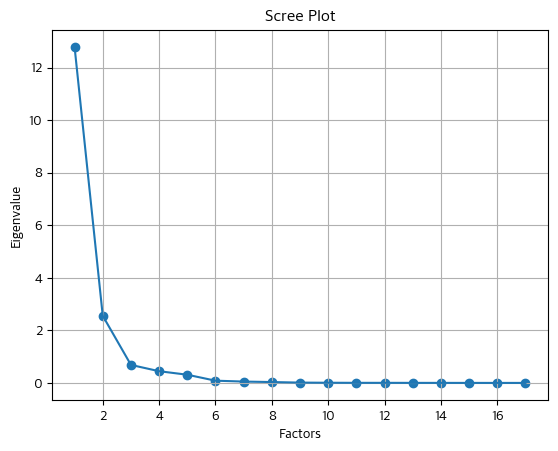

Optimal number of factors (Elbow Method): 1
Number of factors according to Kaiser Criterion: 2


In [ ]:
# Conformity test for common factor analysis (Bartlett's sphericity test, KMO test)
chi_square_value, p_value = calculate_bartlett_sphericity(data_train)
kmo_all, kmo_model = calculate_kmo(data_train)

print("Bartlett's test p-value:", p_value)
print("KMO test:", kmo_model)

# Common factor analysis
# Run a scree test to determine the number of factors
fa = FactorAnalyzer(rotation=None, method='principal', n_factors=data_train.shape[1])
fa.fit(data_train)
ev, v = fa.get_eigenvalues()

# Eigenvalue graph
plt.scatter(range(1, data_train.shape[1]+1), ev)
plt.plot(range(1, data_train.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Select the point where 'elbow' appears in the above graph as the number of factors
# Calculate differences of eigenvalues
ev_diff = np.diff(ev)
# Find the point where the difference value is minimum (the 'elbow' point just before this point)
elbow_point = np.argmin(ev_diff) + 1  # Index Correction
print("Optimal number of factors (Elbow Method):", elbow_point)
# Calculate the number of factors with eigenvalues ​​greater than 1
n_factors_kaiser = (ev > 1).sum()
print("Number of factors according to Kaiser Criterion:", n_factors_kaiser)

Factor Loadings:
                                              0         1
Date                                                    
Seoul_apartment_sale_price_index      0.007446  1.006327
Busan_apartment_sale_price_index      0.719938  0.674877
Daegu_apartment_sale_price_index      0.598221  0.714891
Incheon_apartment_sale_price_index    0.150349  0.740936
Gwangju_apartment_sale_price_index    0.581617  0.774772
Daejeon_apartment_sale_price_index    0.539736  0.747848
Ulsan_apartment_sale_price_index      0.885696  0.417880
Sejong_apartment_sale_price_index     0.428811  0.727391
Gyeonggi_apartment_sale_price_index   0.126231  0.906564
Gangwon_apartment_sale_price_index    0.742842  0.612136
Chungbuk_apartment_sale_price_index   0.979413  0.197577
Chungnam_apartment_sale_price_index   0.966087  0.183671
Jeonbuk_apartment_sale_price_index    0.843762  0.399064
Jeonnam_apartment_sale_price_index    0.646887  0.704552
Gyeongbuk_apartment_sale_price_index  0.932989  0.194081
Gyeongnam_apa

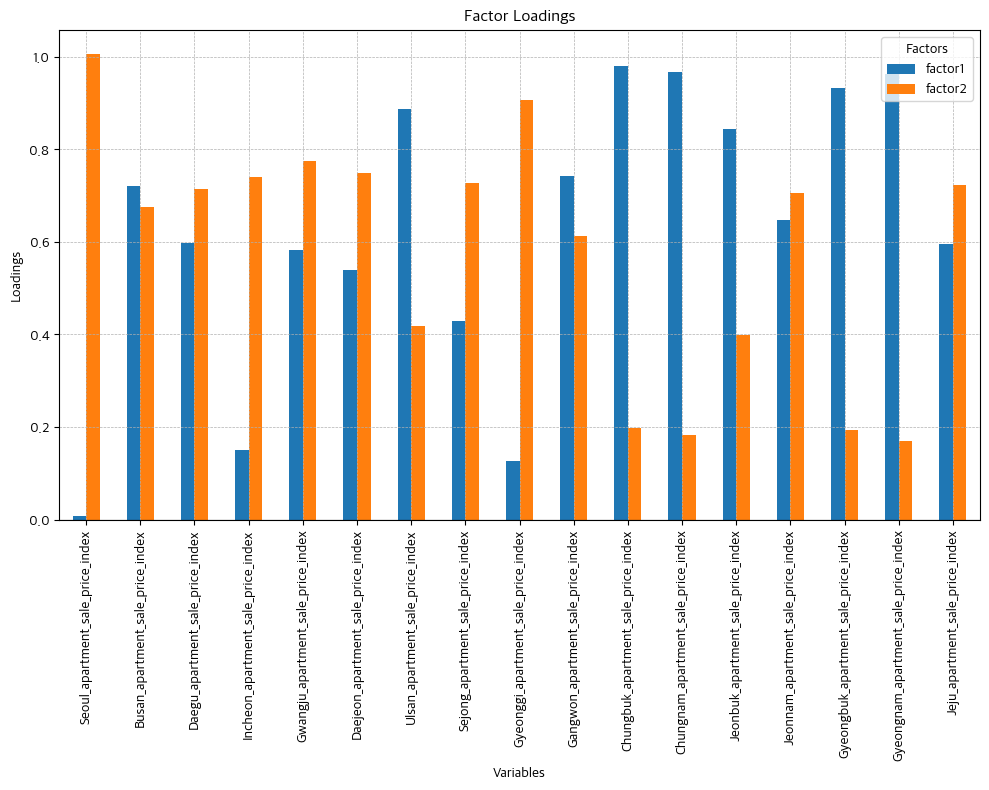

In [17]:
# Factor Analyze
fa = FactorAnalyzer(rotation='varimax', n_factors=2)
fa.fit(data_train)
loads = fa.loadings_
print("Factor Loadings:\n", pd.DataFrame(loads, index=data_train.columns))

variances = fa.get_factor_variance()
print("Factor Variances:", variances) 

loadings = pd.DataFrame(fa.loadings_, index=data_train.columns)
loadings.columns = ['factor1','factor2']

# Factor Loading Plot
fig, ax = plt.subplots(figsize=(10, 8))
loadings.plot(kind='bar', ax=ax)
ax.set_title('Factor Loadings')
ax.set_ylabel('Loadings')
ax.set_xlabel('Variables')
ax.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Factors')
plt.tight_layout()
plt.show()

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_31334/867226923.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(pd.to_datetime(data.index),(data * loadings['factor1']).sum(axis=1)*100/(data * loadings['factor1']).sum(axis=1)[142],label="factor 1")
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_31334/867226923.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(pd.to_datetime(data.index),(data * loadings['factor2']).sum(axis=1)*100/(data * loadings['factor2']).sum(axis=1)[142],label="factor 2")


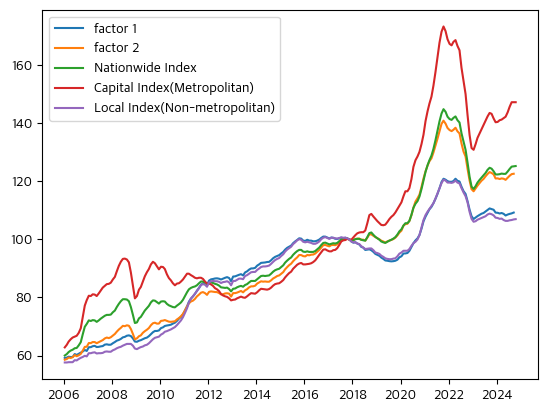

In [16]:
plt.plot(pd.to_datetime(data.index),(data * loadings['factor1']).sum(axis=1)*100/(data * loadings['factor1']).sum(axis=1)[142],label="factor 1")
plt.plot(pd.to_datetime(data.index),(data * loadings['factor2']).sum(axis=1)*100/(data * loadings['factor2']).sum(axis=1)[142],label="factor 2")
plt.plot(pd.to_datetime(df.index),df.iloc[:,0].values, label="Nationwide Index")
plt.plot(pd.to_datetime(df.index),df.iloc[:,1].values, label="Capital Index(Metropolitan)")
plt.plot(pd.to_datetime(df.index),df.iloc[:,2].values, label="Local Index(Non-metropolitan)")
plt.legend()
plt.show()

In [8]:
factor1 = (data * loadings['factor1']).sum(axis=1)*100/(data * loadings['factor1']).sum(axis=1)[142]
factor2 = (data * loadings['factor2']).sum(axis=1)*100/(data * loadings['factor2']).sum(axis=1)[142]

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_31334/3196912643.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  factor1 = (data * loadings['factor1']).sum(axis=1)*100/(data * loadings['factor1']).sum(axis=1)[142]
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_31334/3196912643.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  factor2 = (data * loadings['factor2']).sum(axis=1)*100/(data * loadings['factor2']).sum(axis=1)[142]


### Load Dataset

In [68]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

In [69]:
column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

In [51]:
df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
factor_df = pd.DataFrame([])
factor_df["factor1"] = factor1
factor_df["factor2"] = factor2
factor_df = factor_df.iloc[:-1,:]
factor_df = factor_df.dropna()
df = pd.concat([df,factor_df],axis=1) 
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()
x_df = df[column]

# train : test = 8 : 2
X_train, X_test = train_test_split(x_df, test_size=0.2, shuffle=False)


### Granger Causality Test to define model spec of SEM

In [55]:
def adf_test(series, name=''):
    if series.isnull().any() or np.isinf(series).any():
        print(f"Error: {name} contains NaN or infinite values which must be cleaned before ADF test.")
        return False
    r = adfuller(series, autolag='AIC')
    p_value = r[1]
    print(f'ADF Statistic for {name}: {r[0]:.4f}')
    print(f'p-value for {name}: {p_value:.4f}')
    return p_value < 0.05

# Make Stationary
def process_series(series, name):
    print(f"\nProcessing {name}")
    if adf_test(series, name):
        print(f"{name} is already stationary.")
        return series
    
    # First Difference
    diff = series.diff().dropna()
    if diff.empty or not adf_test(diff, f'{name}_1st_diff'):
        # Second Difference
        diff2 = diff.diff().dropna()
        if diff2.empty or not adf_test(diff2, f'{name}_2nd_diff'):
            print(f"{name} is still non-stationary after all transformations.")
            return None
        else:
            print(f"{name}_2nd_diff is now stationary.")
            return diff2
    else:
        print(f"{name}_1st_diff is now stationary.")
        return diff

results = {}
for name, column in X_train.items():
    result = process_series(column, name)
    if result is not None:
        results[f"{name}"] = result 
        
stationary_df = pd.DataFrame(results)



Processing call_interest_rate
ADF Statistic for call_interest_rate: -1.5869
p-value for call_interest_rate: 0.4902
ADF Statistic for call_interest_rate_1st_diff: -5.9949
p-value for call_interest_rate_1st_diff: 0.0000
call_interest_rate_1st_diff is now stationary.

Processing government_bond_3yr
ADF Statistic for government_bond_3yr: -0.5966
p-value for government_bond_3yr: 0.8718
ADF Statistic for government_bond_3yr_1st_diff: -4.3003
p-value for government_bond_3yr_1st_diff: 0.0004
government_bond_3yr_1st_diff is now stationary.

Processing deposit_bank_loan_rate_avg
ADF Statistic for deposit_bank_loan_rate_avg: -0.6401
p-value for deposit_bank_loan_rate_avg: 0.8617
ADF Statistic for deposit_bank_loan_rate_avg_1st_diff: -8.2294
p-value for deposit_bank_loan_rate_avg_1st_diff: 0.0000
deposit_bank_loan_rate_avg_1st_diff is now stationary.

Processing KOSPI_index
ADF Statistic for KOSPI_index: -2.1641
p-value for KOSPI_index: 0.2195
ADF Statistic for KOSPI_index_1st_diff: -11.0249
p-va

In [90]:
stationary_df_dropna = stationary_df.dropna()
granger_value = {}
# 그레인저 인과성 테스트 함수 및 최소 p-value 래그 저장
def granger_test(data, target, maxlag=12):
    min_p_values = {}
    for col in data.columns:
        if col != target:
            test_result = grangercausalitytests(data[[target, col]], maxlag=maxlag, verbose=False)
            min_p_value = float('inf')
            min_p_lag = 0
            for lag, result in test_result.items():
                p_value = result[0]['ssr_chi2test'][1]  # p-value
                if p_value < min_p_value:
                    min_p_value = p_value
                    min_p_lag = lag
            if min_p_value < 0.05:
                min_p_values[col] = min_p_lag # round(min_p_value,3))
    granger_value[target] = min_p_values
    return min_p_values

for col in X_train.columns:
    anw = granger_test(X_train, col, 23)

In [91]:
granger_value

{'call_interest_rate': {'government_bond_3yr': 11,
  'deposit_bank_loan_rate_avg': 23,
  'KOSPI_index': 1,
  'KOSDAQ_index': 1,
  'M2_Korea': 23,
  'M2_USA': 22,
  'broad_liquidity': 22,
  'CPI_growth_rate': 22,
  'USD_KRW_exchange_rate': 1,
  'real_GDP_growth_rate': 1,
  'residential_building_start_status': 20,
  'residential_building_permit_status': 23,
  'construction_production_index_seasonally_adjusted': 23},
 'government_bond_3yr': {'call_interest_rate': 16,
  'deposit_bank_loan_rate_avg': 15,
  'KOSPI_index': 20,
  'KOSDAQ_index': 4,
  'M2_Korea': 4,
  'M2_USA': 3,
  'broad_liquidity': 20,
  'USD_KRW_exchange_rate': 5,
  'real_GDP_growth_rate': 17,
  'residential_building_permit_status': 23,
  'construction_production_index_seasonally_adjusted': 22},
 'deposit_bank_loan_rate_avg': {'call_interest_rate': 11,
  'government_bond_3yr': 14,
  'KOSPI_index': 13,
  'KOSDAQ_index': 1,
  'M2_Korea': 23,
  'M2_USA': 2,
  'broad_liquidity': 20,
  'USD_KRW_exchange_rate': 5,
  'real_GDP_gro

In [92]:
print("interest_rate")
print(set.intersection(
                set(granger_value['call_interest_rate'].keys()),
                set(granger_value['government_bond_3yr'].keys()),
                set(granger_value['deposit_bank_loan_rate_avg'].keys())))
print("-----------")
print("stock")
print(set.intersection(
                set(granger_value['KOSPI_index'].keys()),
                set(granger_value['KOSDAQ_index'].keys()),
                set(granger_value['NASDAQ_index'].keys())))
print("-----------")
print("money_supply")
print(set.intersection(
                set(granger_value["M2_Korea"].keys()),
                set(granger_value["M2_USA"].keys())))
print("-----------")
print("construction")
print(set.intersection(
                set(granger_value["residential_building_start_status"].keys()),
                set(granger_value["residential_building_permit_status"].keys())))



interest_rate
{'real_GDP_growth_rate', 'broad_liquidity', 'construction_production_index_seasonally_adjusted', 'KOSDAQ_index', 'M2_USA', 'residential_building_permit_status', 'M2_Korea', 'USD_KRW_exchange_rate', 'KOSPI_index'}
-----------
stock
{'government_bond_3yr', 'broad_liquidity', 'M2_USA', 'call_interest_rate', 'CPI_growth_rate', 'deposit_bank_loan_rate_avg', 'M2_Korea', 'USD_KRW_exchange_rate', 'real_GDP_growth_rate'}
-----------
money_supply
{'government_bond_3yr', 'construction_production_index_seasonally_adjusted', 'KOSDAQ_index', 'call_interest_rate', 'KOSPI_index', 'NASDAQ_index', 'USD_KRW_exchange_rate', 'real_GDP_growth_rate'}
-----------
construction
{'government_bond_3yr', 'KOSDAQ_index', 'call_interest_rate', 'CPI_growth_rate', 'deposit_bank_loan_rate_avg', 'M2_Korea', 'KOSPI_index'}


In [97]:
# Define the SEM model specification in semopy syntax
mod_spec = f"""
    # Measurement model
    interest_rate =~ call_interest_rate + government_bond_3yr + deposit_bank_loan_rate_avg
    stock =~ KOSPI_index + KOSDAQ_index + NASDAQ_index
    money_supply =~ M2_Korea + M2_USA
    liquidity =~ broad_liquidity
    inflation =~ CPI_growth_rate
    exchange_rate =~ USD_KRW_exchange_rate
    gdp =~ real_GDP_growth_rate
    construction =~ residential_building_start_status + residential_building_permit_status
    construction_production =~ construction_production_index_seasonally_adjusted

    # Structural model
    interest_rate ~ gdp + liquidity + construction_production + money_supply + exchange_rate
    stock ~ liquidity + interest_rate + gdp + money_supply + inflation + exchange_rate
    money_supply ~ gdp + exchange_rate + stock + construction_production
    liquidity ~ interest_rate + money_supply + inflation + exchange_rate + gdp
    inflation ~ interest_rate + stock + liquidity + exchange_rate + gdp + construction_production
    exchange_rate ~ money_supply + liquidity + gdp
    gdp ~ interest_rate + stock + money_supply + liquidity + inflation + exchange_rate + construction_production
    construction ~ interest_rate + inflation
    construction_production ~ interest_rate + stock + liquidity + inflation + exchange_rate + gdp + construction
"""
spec = mod_spec + """
    factor ~ interest_rate + stock + money_supply + liquidity + inflation + exchange_rate + \
            gdp +\
            construction + construction_production # + housing_construction
    """

### SEM

In [98]:
def z_transform(X, mu, std):
    """
    ==========================
    | X: df, mu: df, std: df |
    ==========================
    """
    return (X-mu)/(std+0.000001)

def inv_z_transform(y, mu, std):
    """
    ====================================
    | y: ndarray, mu: df, std: df      |
    ====================================
    """
    return y * (std+0.000001) + mu

In [99]:
lag = 3 # 3-month ahead

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
df = df.shift(lag) # predict the future by taking past data of explanatory variables
df = df.dropna()
factor_df = pd.DataFrame([])
factor_df["factor1"] = factor1
factor_df["factor2"] = factor2
factor_df = factor_df.iloc[:-1,:]
factor_df = factor_df.dropna()
df = pd.concat([df,factor_df],axis=1) 
df = df[18:]
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# target = "factor1"
def train_sem(target_value): 
    x_df = df[column]
    y_df = df[target_value]

    # train : valid : test = 6 : 2 : 2
    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.4, shuffle=False)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

    x_df_mu, x_df_std = X_train.mean(), X_train.std()
    y_df_mu, y_df_std = y_train.mean(), y_train.std()

    X_train = z_transform(X_train, x_df_mu, x_df_std)
    X_valid = z_transform(X_valid, x_df_mu, x_df_std)
    X_test = z_transform(X_test, x_df_mu, x_df_std)
    y_train = z_transform(y_train, y_df_mu, y_df_std)
    y_valid = z_transform(y_valid, y_df_mu, y_df_std)
    y_test = z_transform(y_test, y_df_mu, y_df_std)

    df_train_inv = pd.concat([pd.DataFrame(y_train), X_train], axis=1)
    df_valid_inv = pd.concat([pd.DataFrame(y_valid), X_valid], axis=1)
    df_test_inv = pd.concat([pd.DataFrame(y_test), X_test], axis=1)
    
    # Instantiate and fit the model
    spec = mod_spec + f"""
    {target_value} ~ interest_rate + stock + money_supply + liquidity + inflation + exchange_rate + \
            gdp +\
            construction + construction_production # + housing_construction
    """
    model = Model(spec)

    optimization_methods = ['MLW', 'ULS', 'GLS', 'WLS', 'DWLS', 'FIML']
    best_method = ''
    lowest_rmse = float('inf')

    for method in optimization_methods:
        model = Model(spec)
        try:
            model.fit(data=df_train_inv, obj=method)
            estimates = model.inspect()
            y_pred_valid = model.predict(df_valid_inv.drop(target_value, axis=1))[target_value]
            mse = mean_squared_error(df_valid_inv[target_value], y_pred_valid)
            if mse < lowest_rmse:
                lowest_rmse = mse
                best_method = method

        except Exception as e:
            # 오류가 발생했을 때 실행될 코드
            print(f"An error occurred: {e} in {method}")
        continue

    print(f"Best optimization method: {best_method} with MSE: {lowest_rmse:.4f}")
    model = Model(spec)
    opt_res = model.fit(data = df_train_inv,
                        obj = best_method)
                                    # "MLW" (the default): Wishart loglikelihood;
                                    # "ULS": Unweighted Least Squares;
                                    # "GLS": Generalized Least Squares;
                                    # "WLS": Weighted Least Squares (also known as an Asymptotic Distribution-Free Estimator);
                                    # "DWLS": Diagonally Weighted Least Squares (also known as robust WLS);
                                    # "FIML": Full Information Maximum Likelihood (when data has no missing values FIML is effectively a Multivariate Normal Maximum Likelihood).
    estimates = model.inspect()
    

    y_pred_train = model.predict(df_train_inv.drop(target_value, axis=1))[target_value]
    y_pred_valid = model.predict(df_valid_inv.drop(target_value, axis=1))
    y_pred = model.predict(df_test_inv.drop(target_value, axis=1))
    results_df = pd.DataFrame({
        'Actual': df_test_inv[target_value],
        'Predicted': y_pred[target_value]
    })

    # accuracy assessment
    results_df = results_df.dropna()
    mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(df_train_inv.index),y_train,c="b")
    plt.plot(pd.to_datetime(df_train_inv.index),y_pred_train,c="r")
    plt.plot(pd.to_datetime(df_valid_inv.index), df_valid_inv[target_value], c="b")
    plt.plot(pd.to_datetime(df_valid_inv.index), y_pred_valid[target_value],c="r")
    plt.plot(pd.to_datetime(df_test_inv.index), df_test_inv[target_value], label='Actual',c="b")
    plt.plot(pd.to_datetime(df_test_inv.index), y_pred[target_value], label='Predicted',c="r")
    plt.axvline(x=pd.to_datetime(y_valid.index[0]), color='black', linestyle=':', linewidth=3)
    plt.axvline(x=pd.to_datetime(y_test.index[0]), color='black', linestyle=':', linewidth=3)
    plt.title('Actual vs Predicted Factor')
    plt.xlabel('Observations')
    plt.ylabel('Factor')
    plt.legend()
    plt.show()
    
    return pd.concat([inv_z_transform(y_pred_train, y_df_mu, y_df_std),
                      inv_z_transform(y_pred_valid[target_value], y_df_mu, y_df_std),
                      inv_z_transform(y_pred[target_value], y_df_mu, y_df_std)])

In [118]:
# Initialize Digraph from graphviz
dot = Digraph(comment='SEM Model')

# Parse model spec and create nodes and edges
lines = spec.split("\n")
for line in lines:
    line = line.strip()
    if line.endswith('=~'):
        continue
    if '=~' in line:
        latent, indicators = line.split('=~')
        latent = latent.strip()
        indicators = [ind.strip() for ind in indicators.split('+')]
        dot.node(latent, latent, shape='ellipse', color='lightblue')
        for indicator in indicators:
            dot.node(indicator, indicator, shape='box')
            dot.edge(latent, indicator, dir='none')
    elif '~' in line:
        outcome, predictors = line.split('~')
        outcome = outcome.strip()
        predictors = [pred.strip() for pred in predictors.split('+')]
        for predictor in predictors:
            if predictor:
                dot.edge(predictor, outcome)

# Render the graph
output_path = 'sem_model'
dot.render(output_path, format='png', view=True)


'sem_model.png'

Best optimization method: WLS with MSE: 0.0667
Mean Squared Error (MSE): 0.3476
R-squared (R²): -2.0594


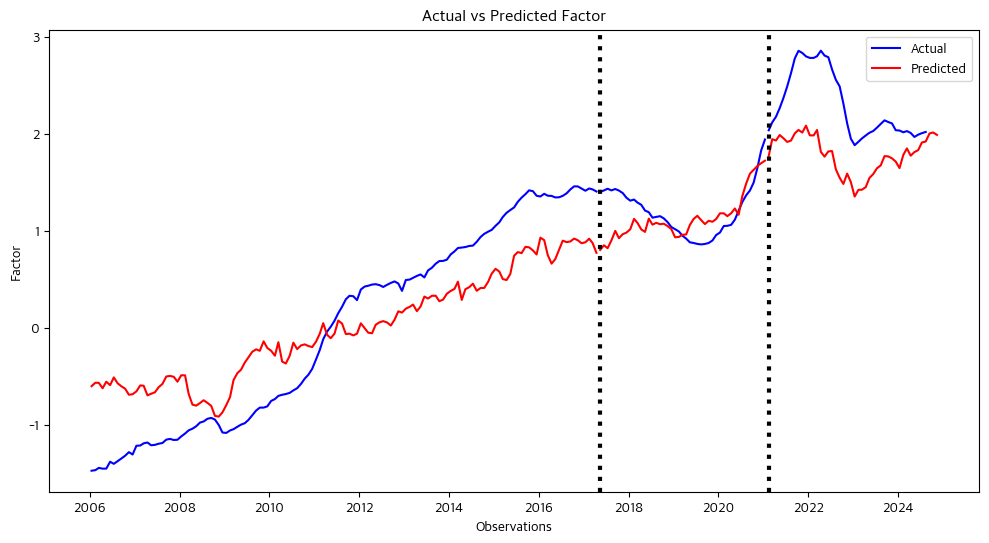

In [119]:
factor1_df = train_sem("factor1")

Best optimization method: FIML with MSE: 0.1077


Mean Squared Error (MSE): 0.3900
R-squared (R²): 0.1478


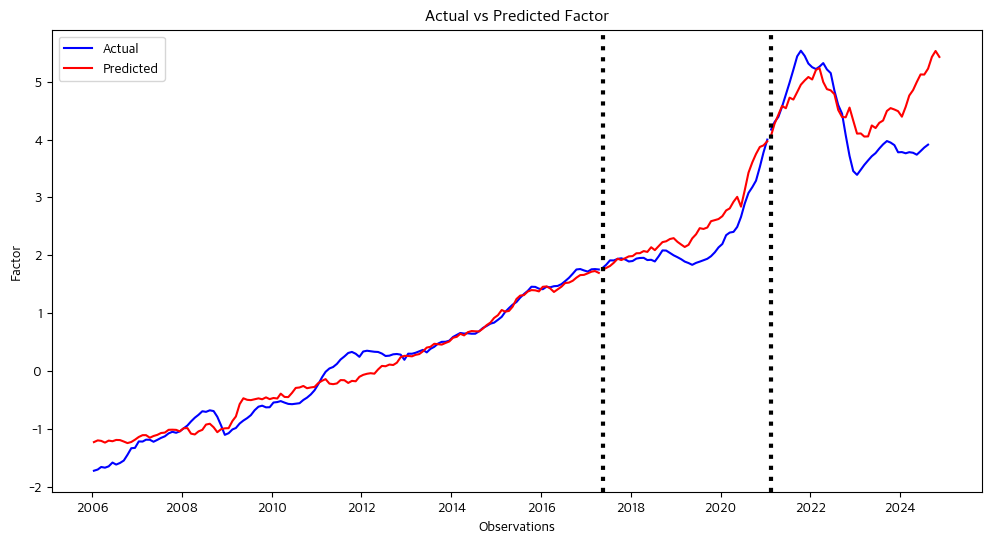

In [120]:
factor2_df = train_sem("factor2")

Target = Common Factor + Individual

In [124]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

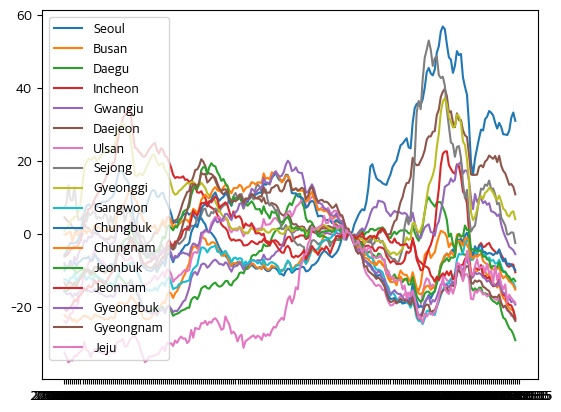

In [125]:
resid = pd.DataFrame([])
for i in range(len(fa.loadings_)):
    f = factor1_df * fa.loadings_[i][0] + factor2_df * fa.loadings_[i][1]
    f = data.iloc[:,i] - f*100/f[142]
    resid[target_column[i]] = f 
    plt.plot(f,label = target_column[i])
plt.legend()
plt.show()
    

### Resid

In [130]:
nf = pd.read_csv(feature_path).T
nf.columns = nf.iloc[0]
nf = nf.iloc[1:]
for col in nf.columns:
    nf[col] = pd.to_numeric(nf[col], errors='coerce')
nf = pd.concat([nf,resid],axis=1)
_df = pd.concat([df,resid],axis=1)
_df_dropna = _df.dropna()

In [ ]:
target = "Gyeonggi"
for i in df.columns:
    print("p-value:{:.4f}".format(stats.pearsonr(_df_dropna[i], _df_dropna[target])[1]))
    plt.scatter(_df_dropna[i], _df_dropna[target],c="b")
    plt.title(f'Relationship of {i} and target')
    plt.xlabel(f'{i}')
    plt.ylabel('target')
    plt.grid(True)
    plt.show()

### MLP

In [134]:
def predict(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    targets = []
    with torch.no_grad():  # No need to track the gradients
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).cpu().numpy())  # Store predictions
            targets.extend(labels.cpu().numpy())  # Store true values
    return predictions, targets

In [136]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1) 

        # self.hidden_size = hidden_size
        # self.num_layers = num_layers
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        X = torch.unsqueeze(x, 0)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x
        # out, _ = self.lstm(X)  # out.size() = (1, seq_length, hidden_dim)
        # out = self.fc(out[0, :, :])
        # return out

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [138]:
_df.columns

Index(['call_interest_rate', 'government_bond_3yr',
       'deposit_bank_loan_rate_avg', 'KOSPI_index', 'KOSDAQ_index',
       'NASDAQ_index', 'M2_Korea', 'M2_USA', 'broad_liquidity',
       'CPI_growth_rate', 'USD_KRW_exchange_rate', 'real_GDP_growth_rate',
       'residential_building_start_status',
       'residential_building_permit_status',
       'construction_production_index_seasonally_adjusted', 'factor1',
       'factor2', 'Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju', 'Daejeon',
       'Ulsan', 'Sejong', 'Gyeonggi', 'Gangwon', 'Chungbuk', 'Chungnam',
       'Jeonbuk', 'Jeonnam', 'Gyeongbuk', 'Gyeongnam', 'Jeju'],
      dtype='object')

### Train and Save model

 19%|█▉        | 97/500 [00:02<00:12, 33.17it/s]


Early stopping triggered.


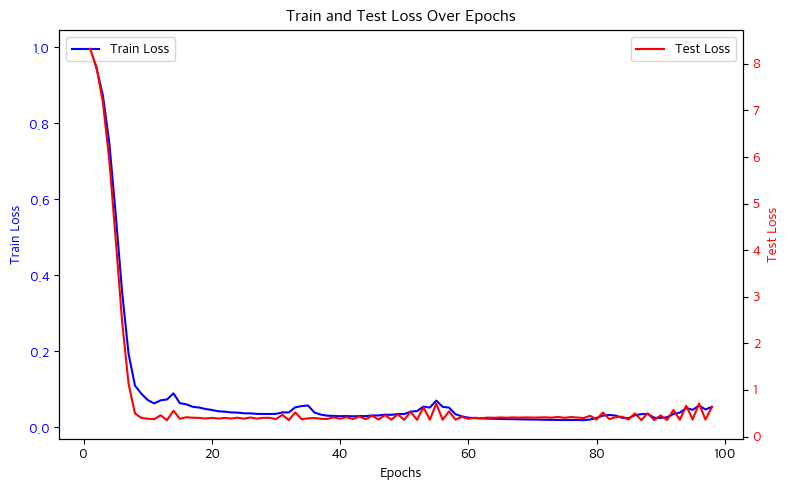

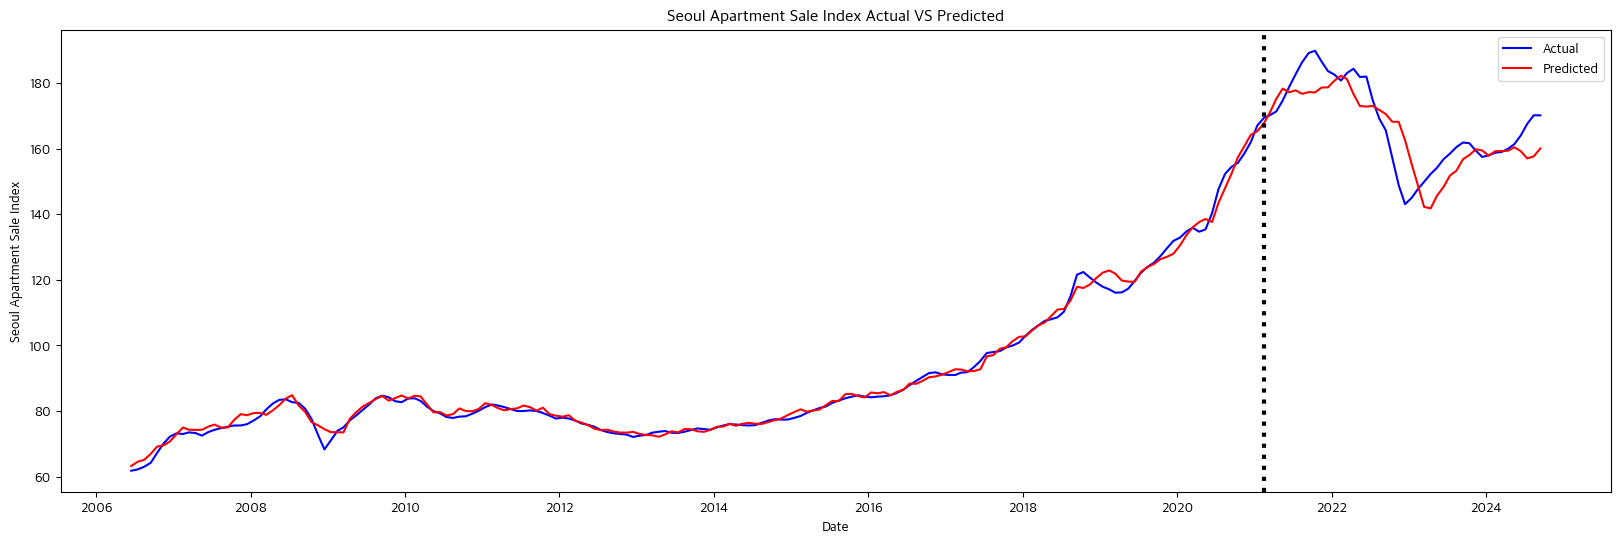

 35%|███▌      | 175/500 [00:05<00:10, 29.88it/s]


Early stopping triggered.


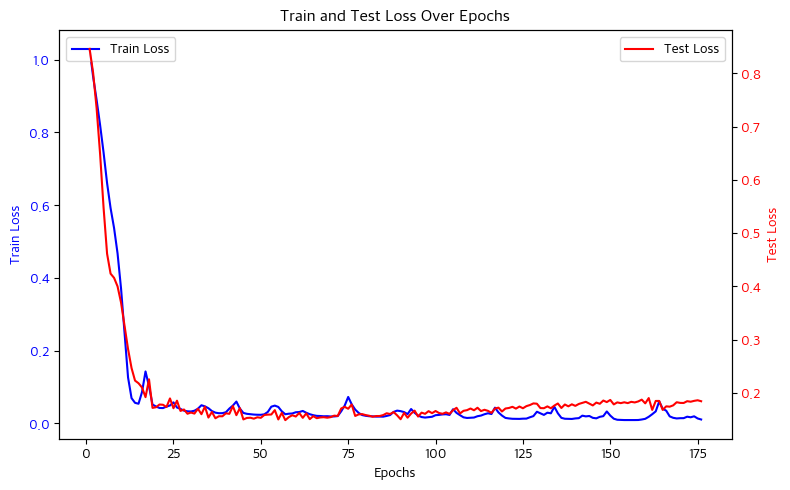

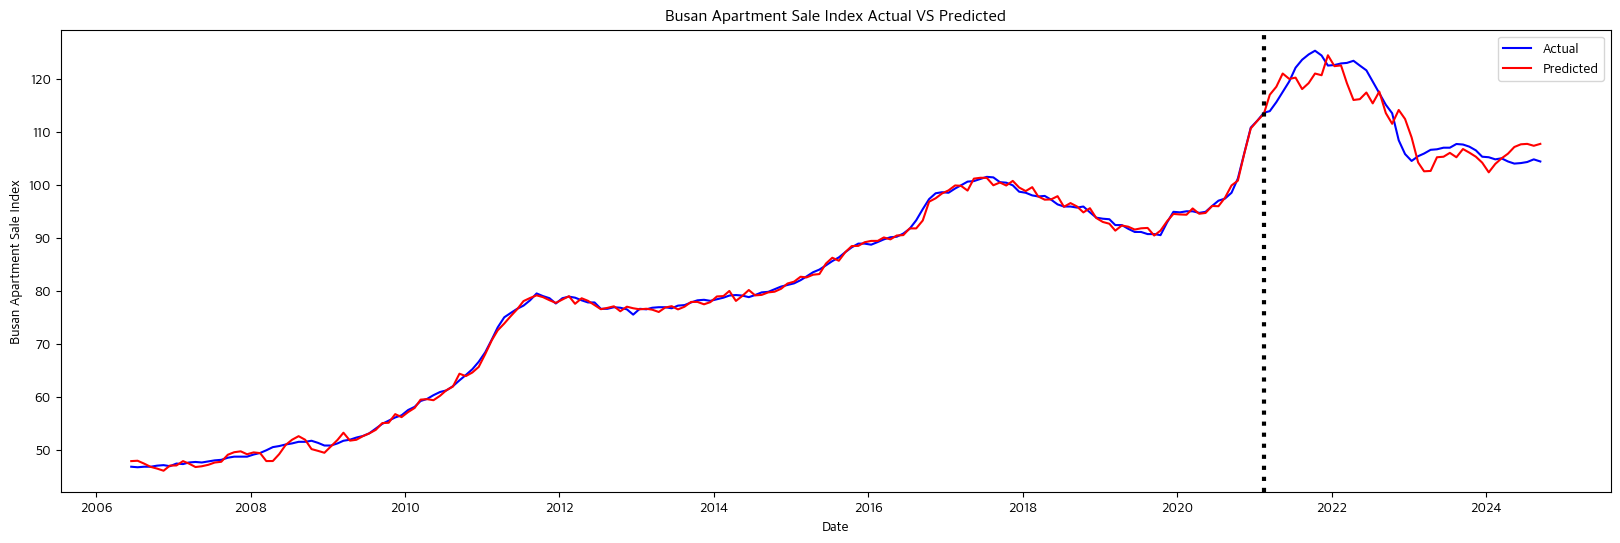

 27%|██▋       | 133/500 [00:03<00:10, 33.79it/s]


Early stopping triggered.


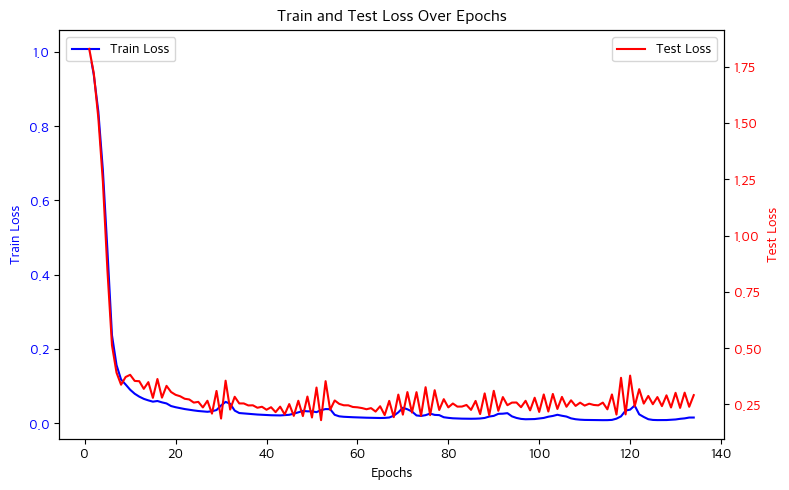

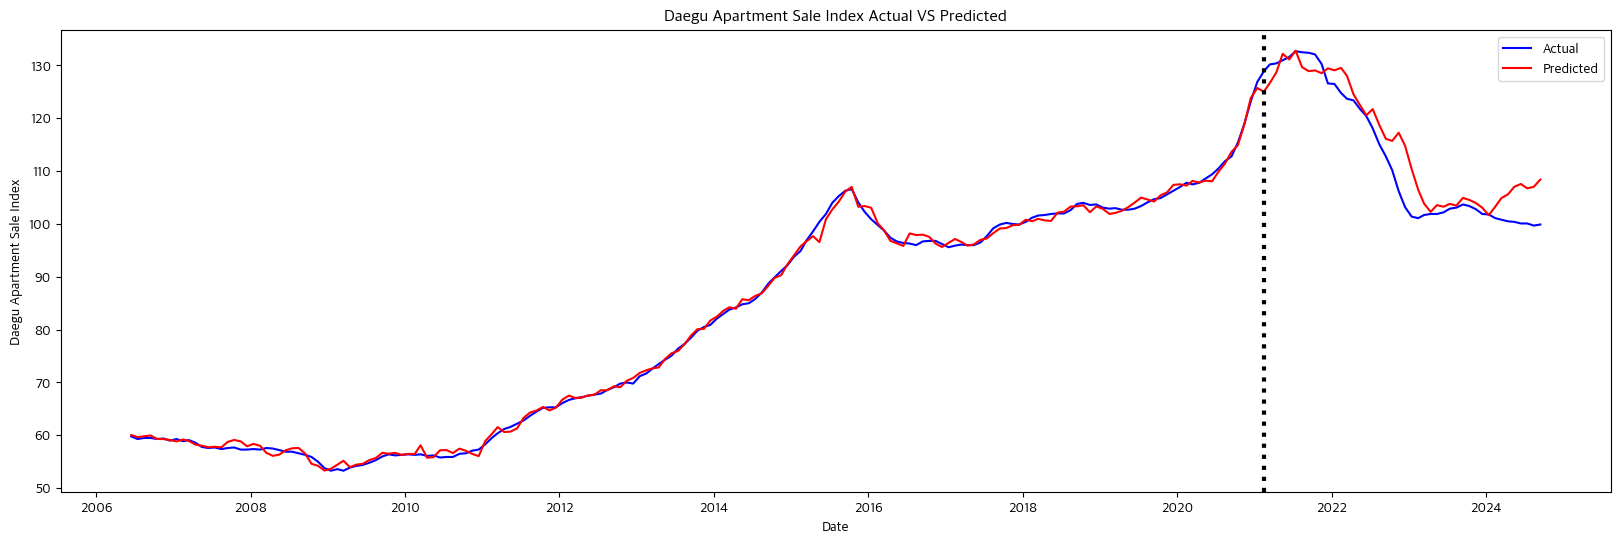

 81%|████████  | 405/500 [00:15<00:03, 26.56it/s]


Early stopping triggered.


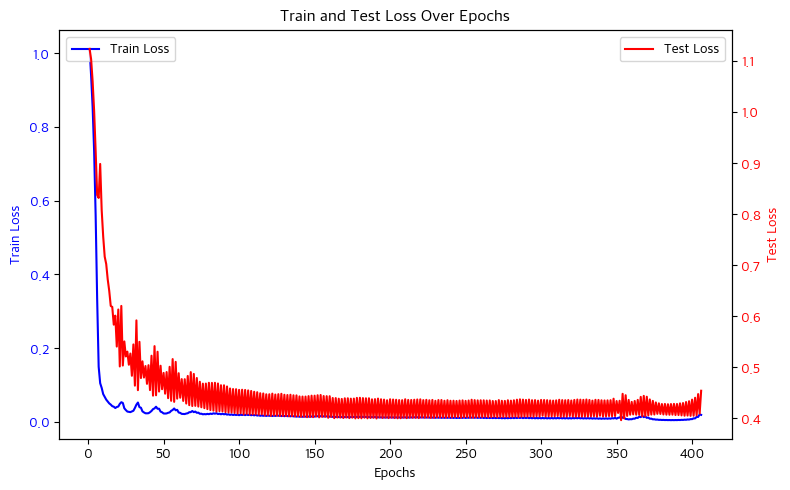

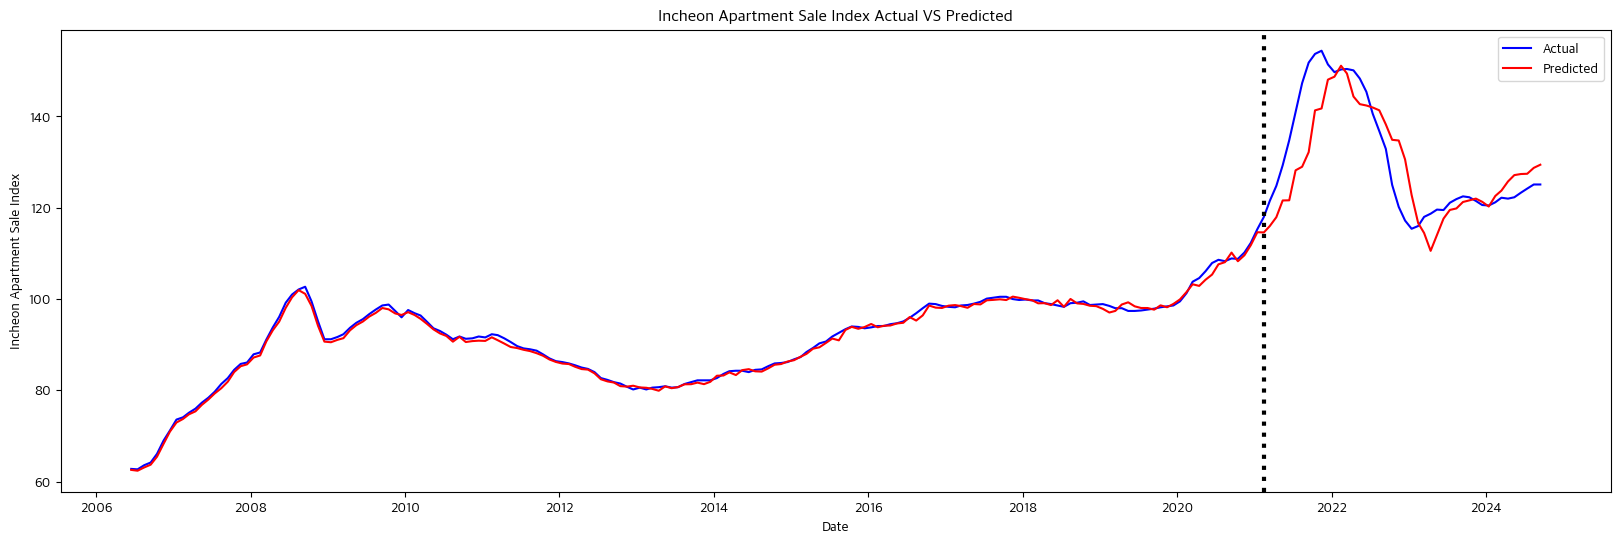

 23%|██▎       | 114/500 [00:03<00:11, 32.82it/s]


Early stopping triggered.


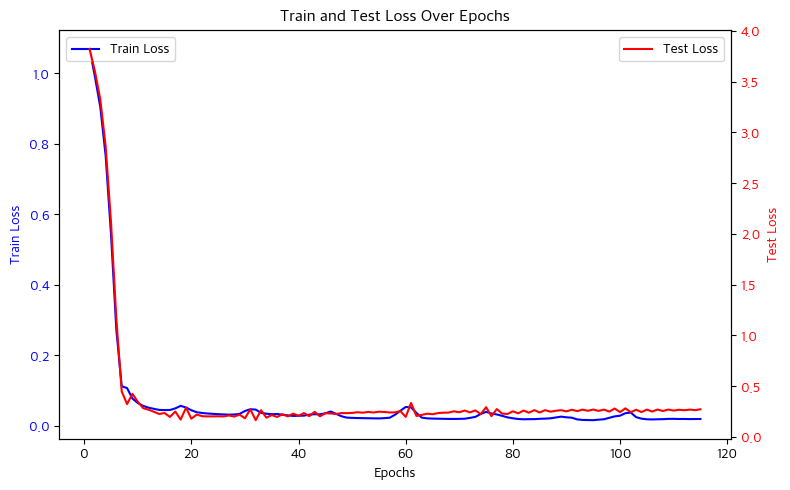

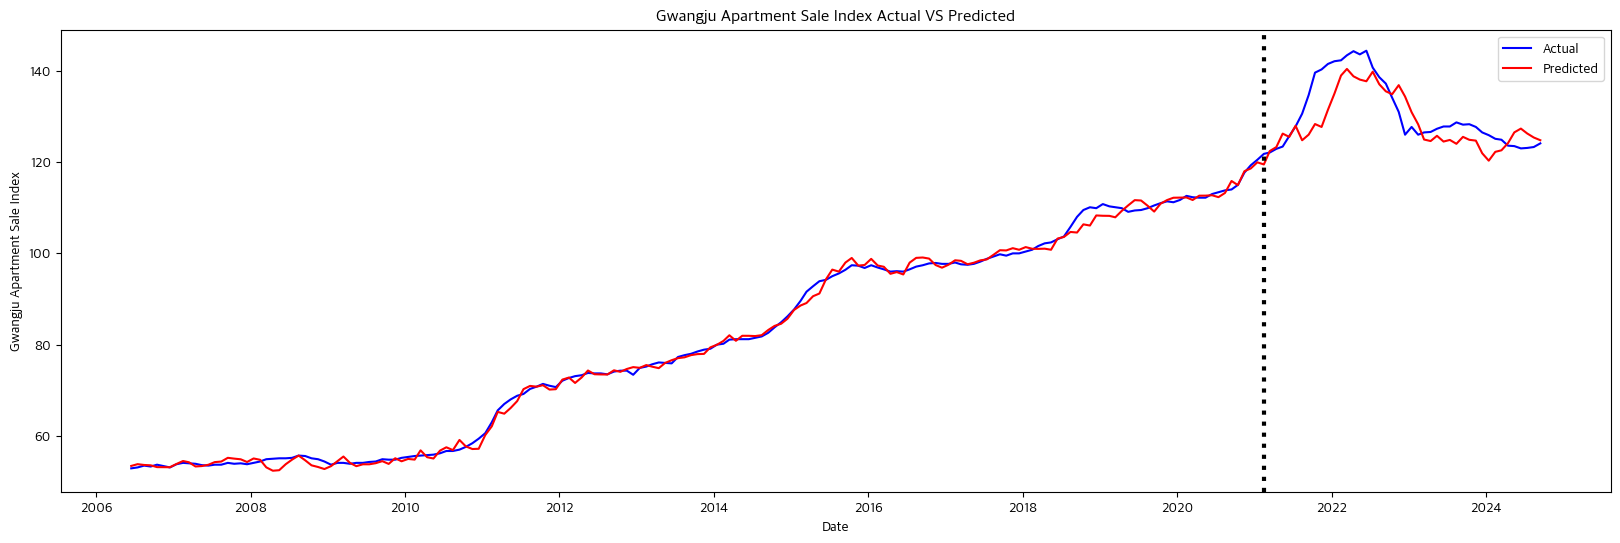

 25%|██▌       | 127/500 [00:03<00:10, 34.21it/s]


Early stopping triggered.


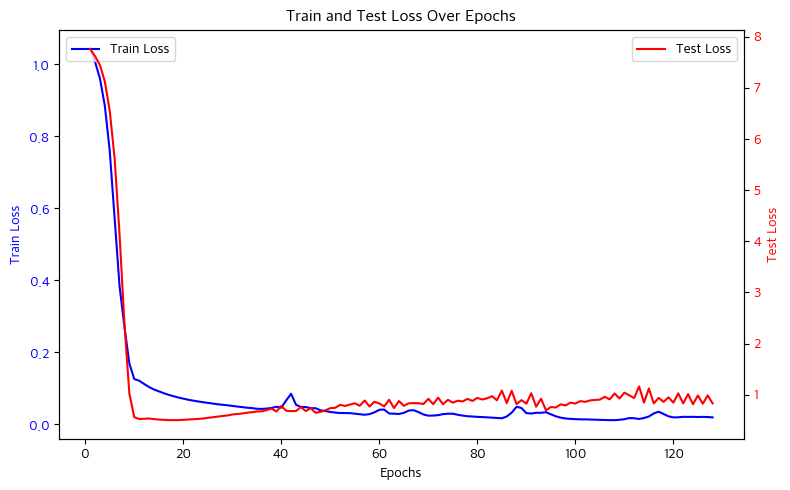

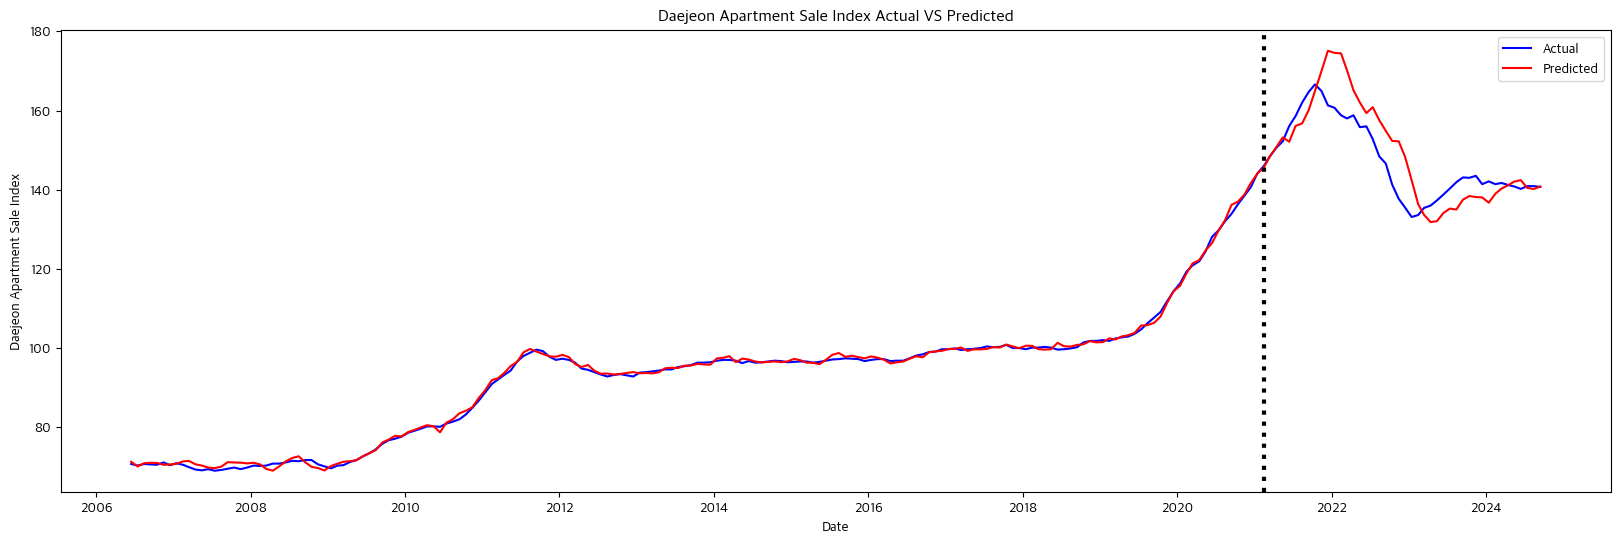

 22%|██▏       | 108/500 [00:03<00:12, 30.75it/s]


Early stopping triggered.


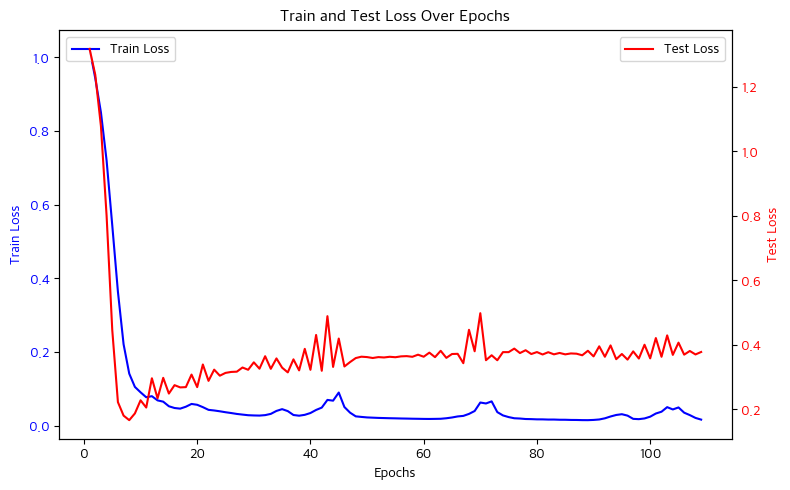

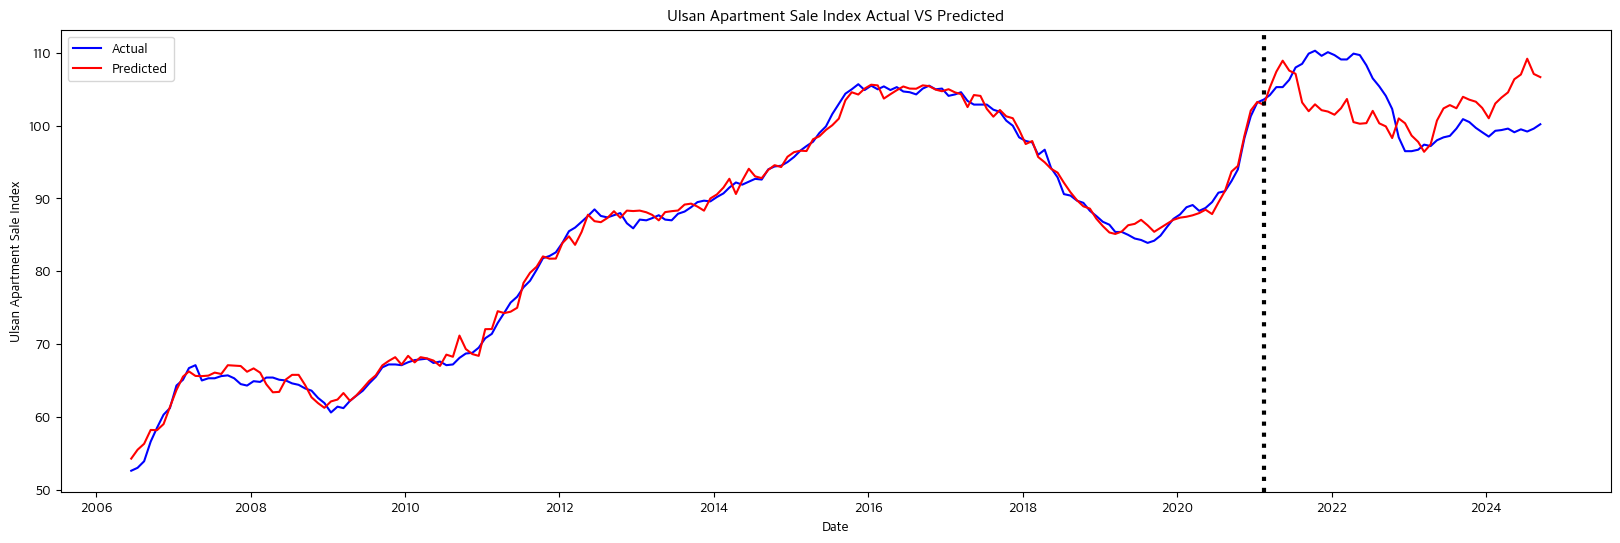

 30%|███       | 151/500 [00:04<00:11, 31.68it/s]


Early stopping triggered.


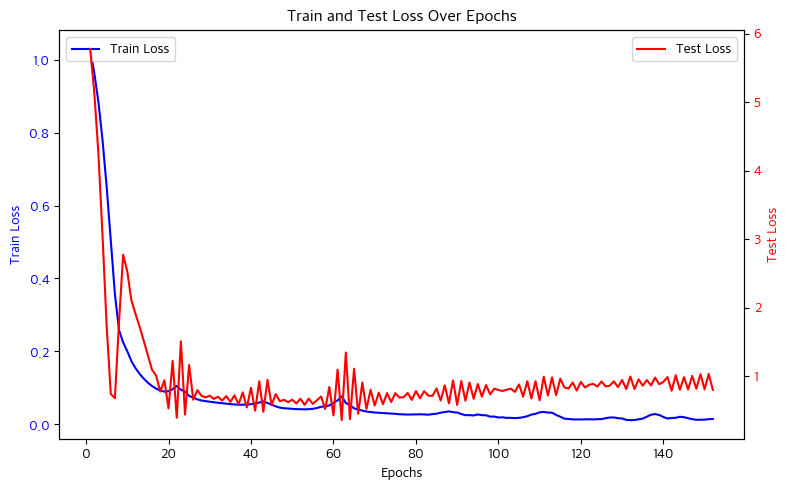

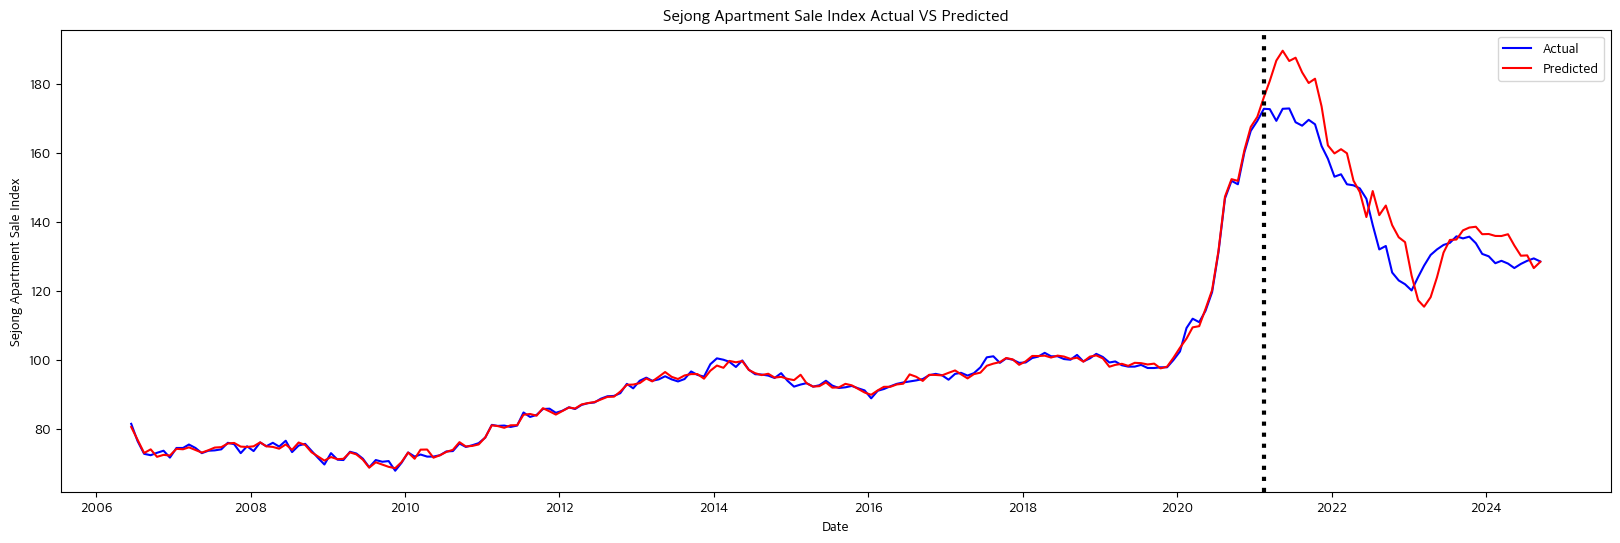

 21%|██        | 106/500 [00:03<00:12, 32.35it/s]


Early stopping triggered.


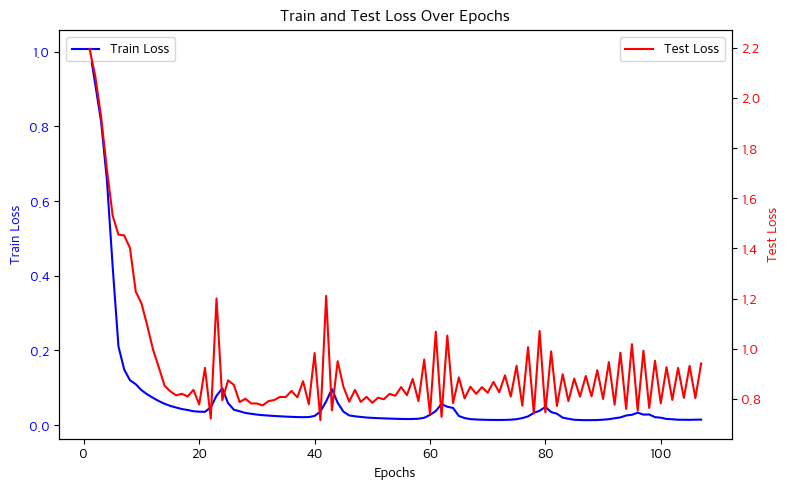

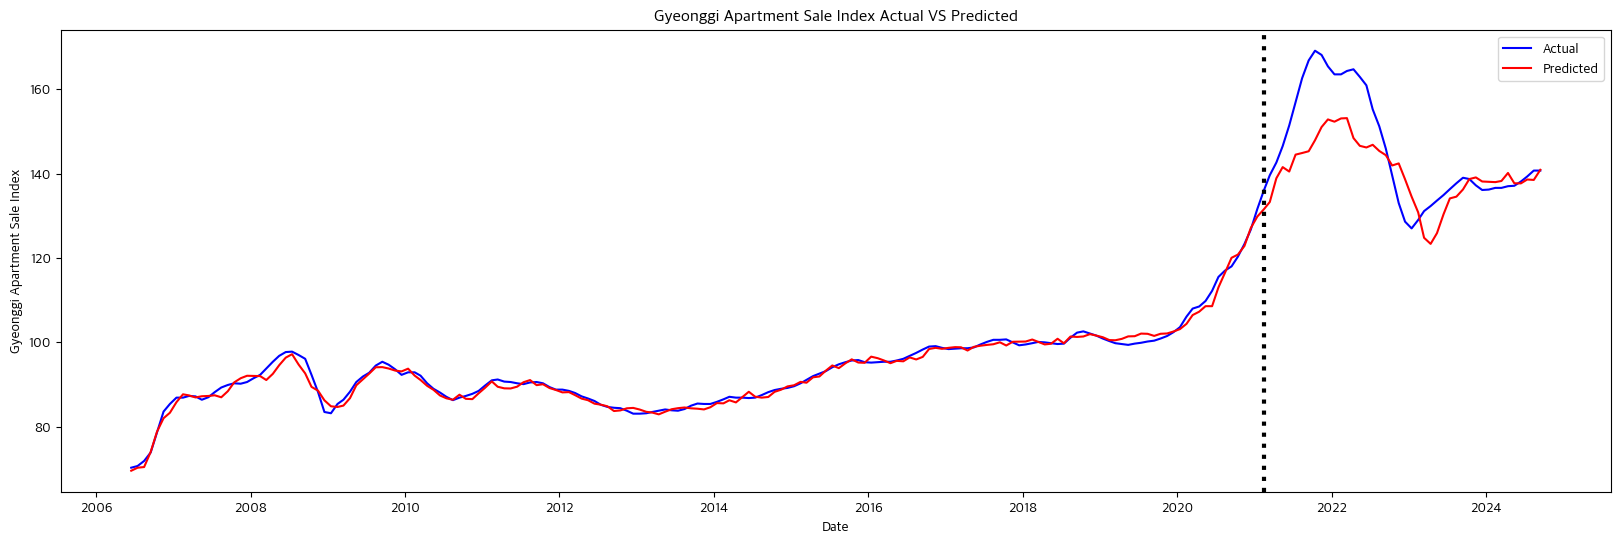

 38%|███▊      | 191/500 [00:05<00:09, 32.54it/s]


Early stopping triggered.


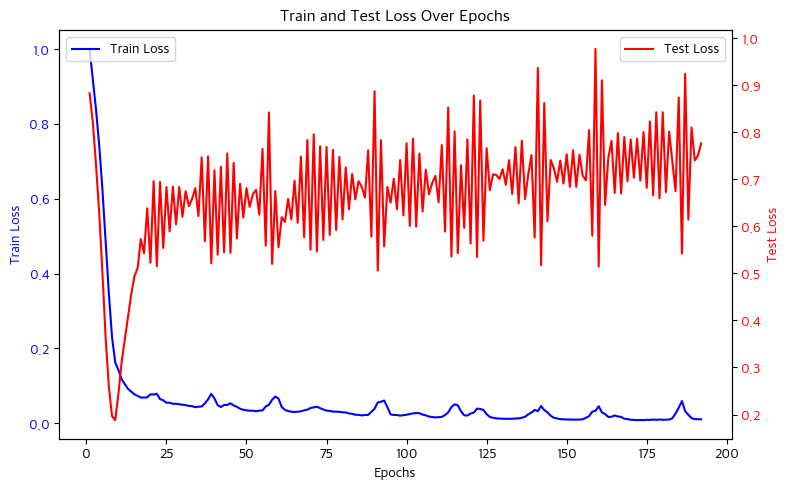

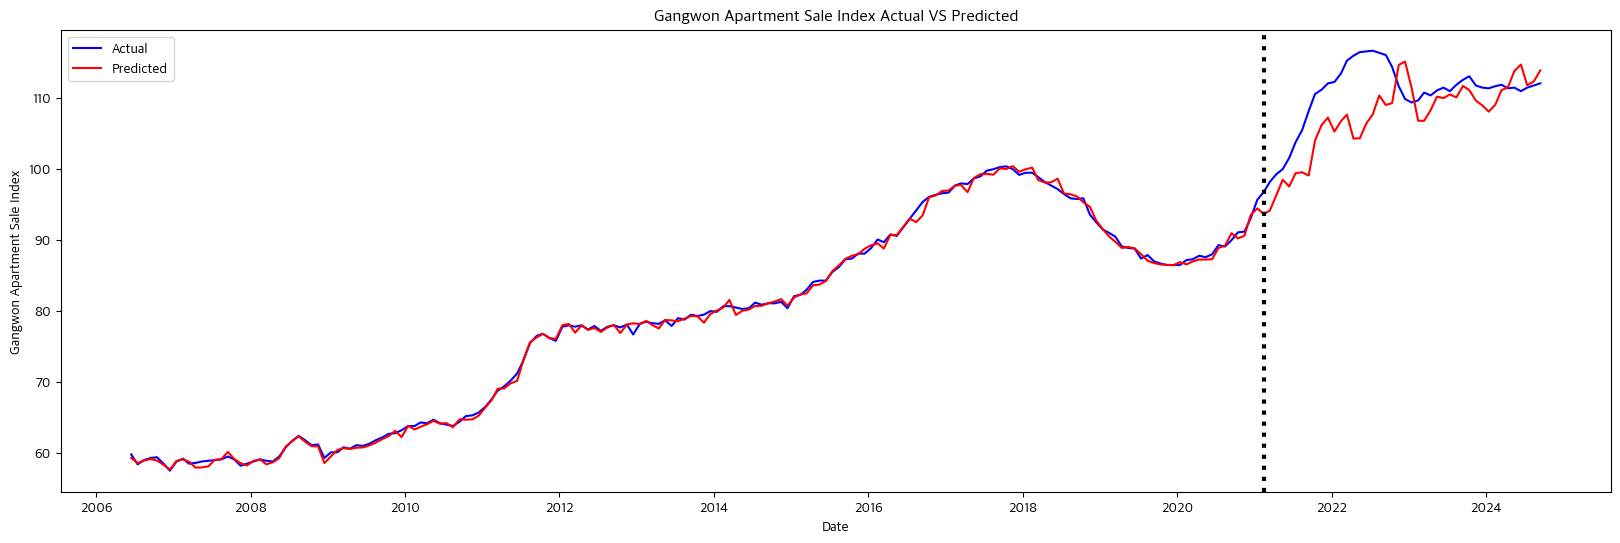

 14%|█▍        | 70/500 [00:02<00:14, 28.98it/s]


Early stopping triggered.


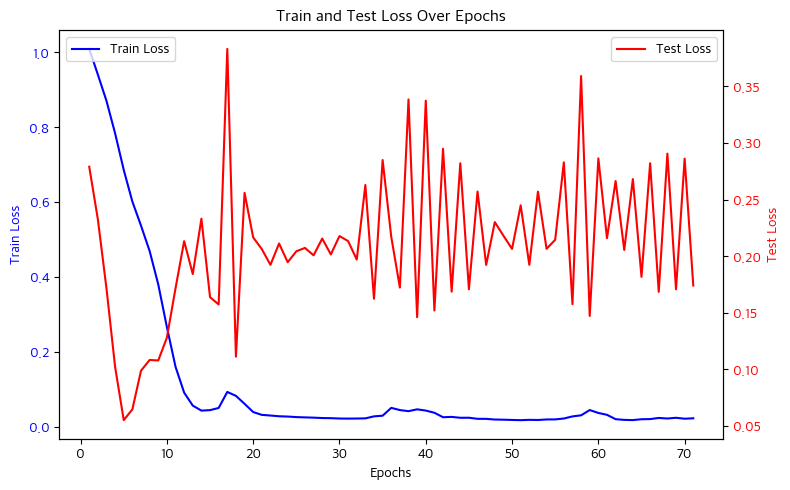

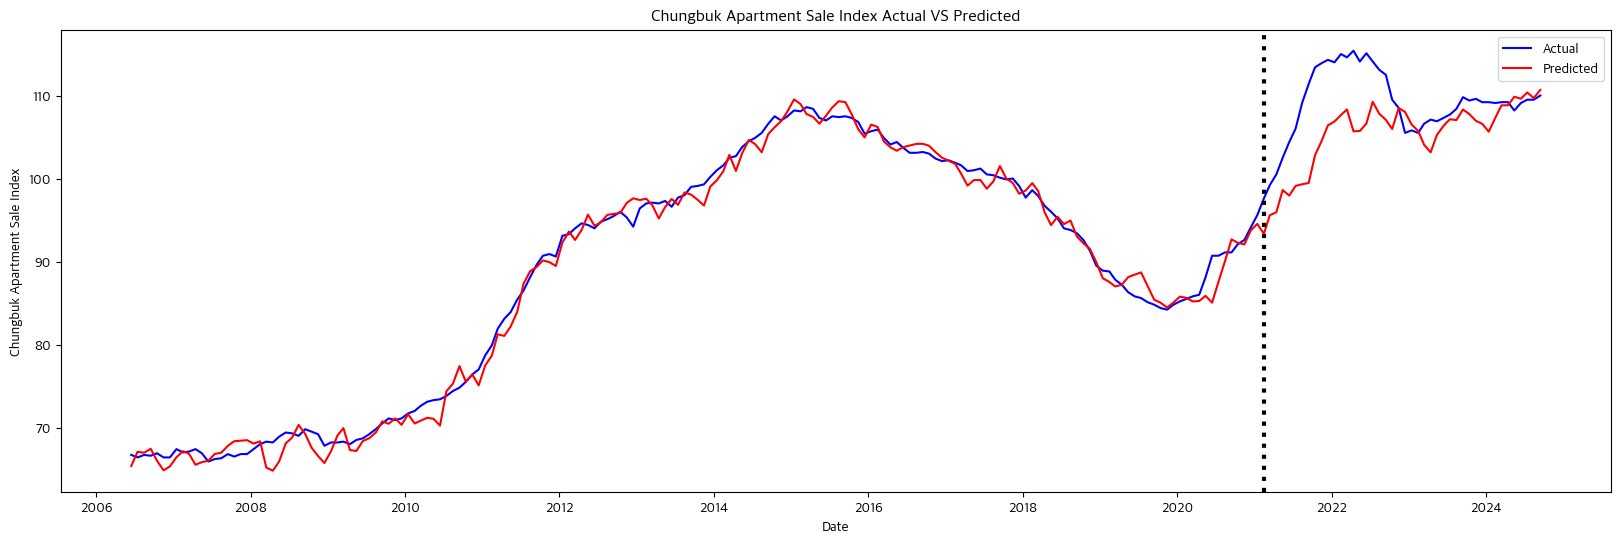

 18%|█▊        | 92/500 [00:02<00:12, 31.84it/s]


Early stopping triggered.


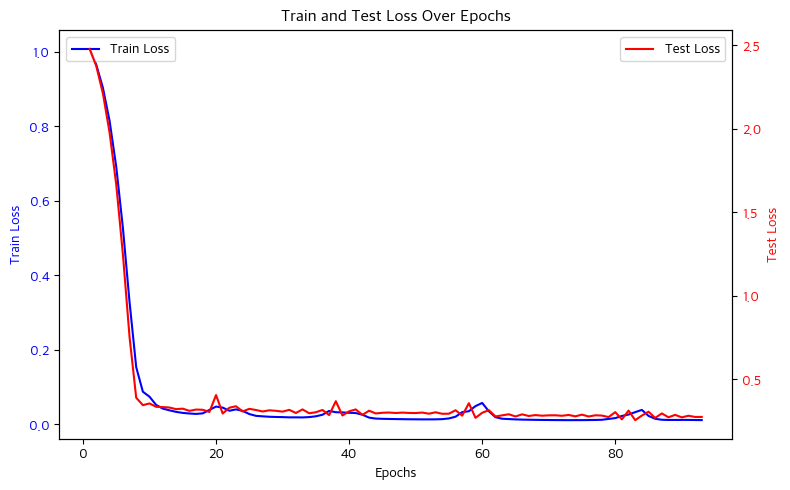

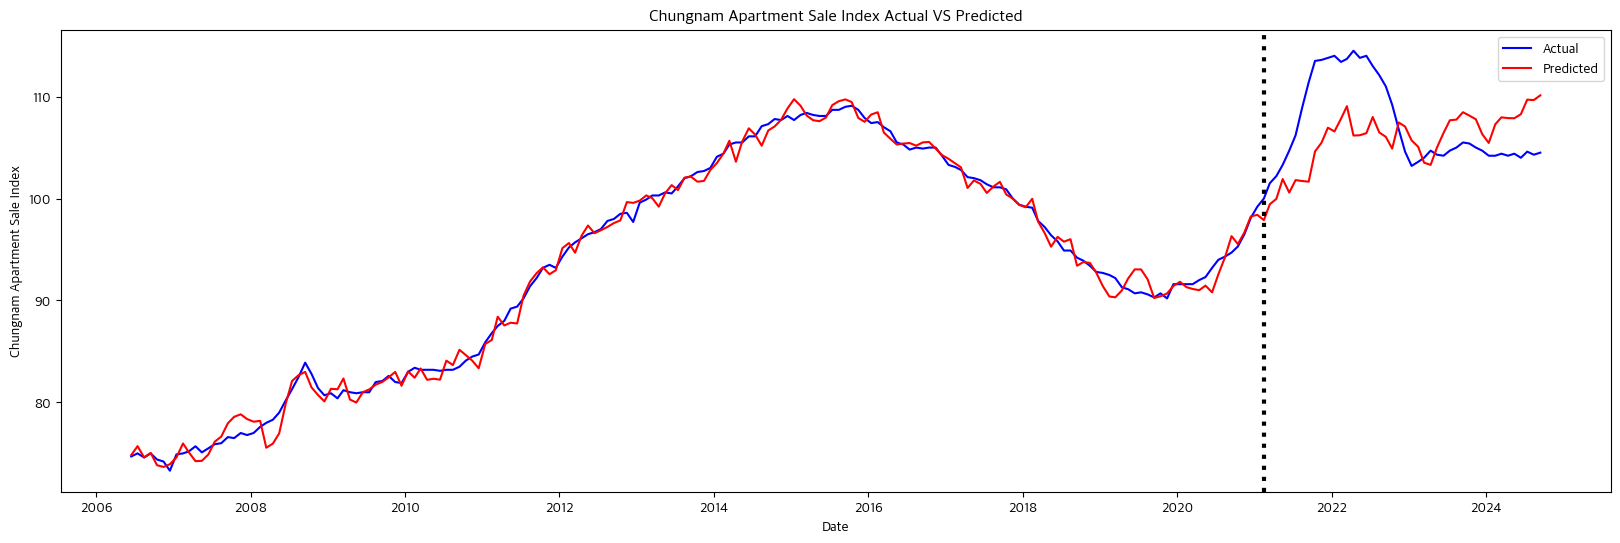

 22%|██▏       | 110/500 [00:03<00:11, 33.93it/s]


Early stopping triggered.


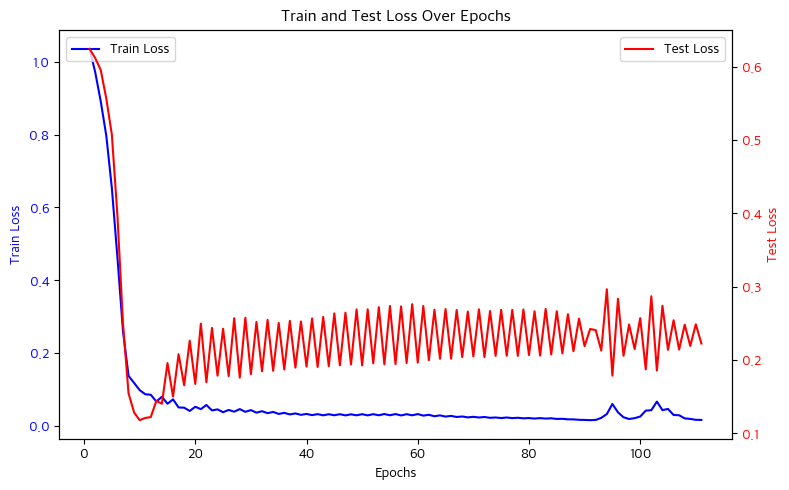

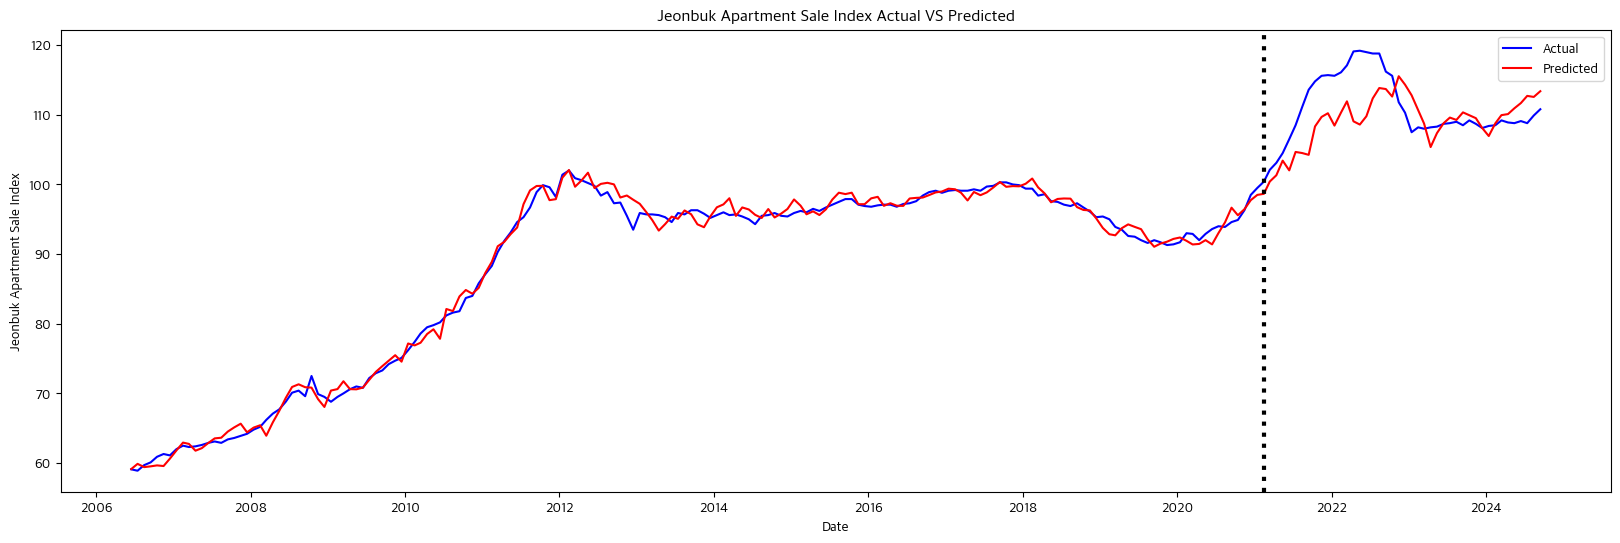

 14%|█▍        | 69/500 [00:02<00:18, 23.00it/s]


Early stopping triggered.


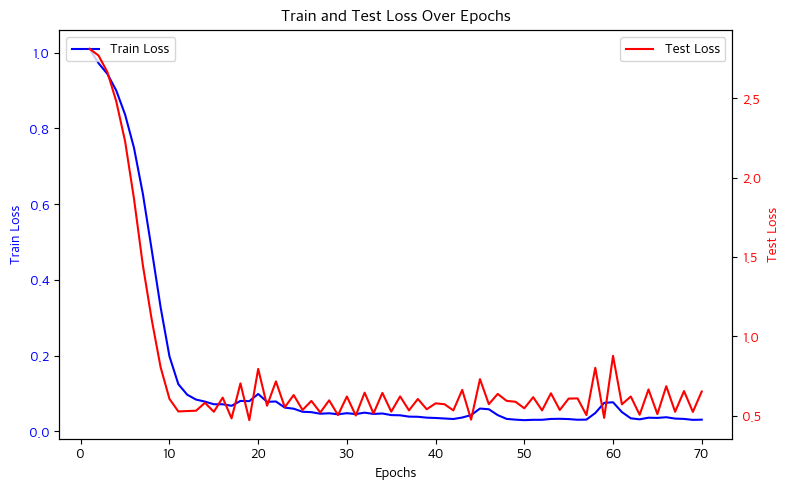

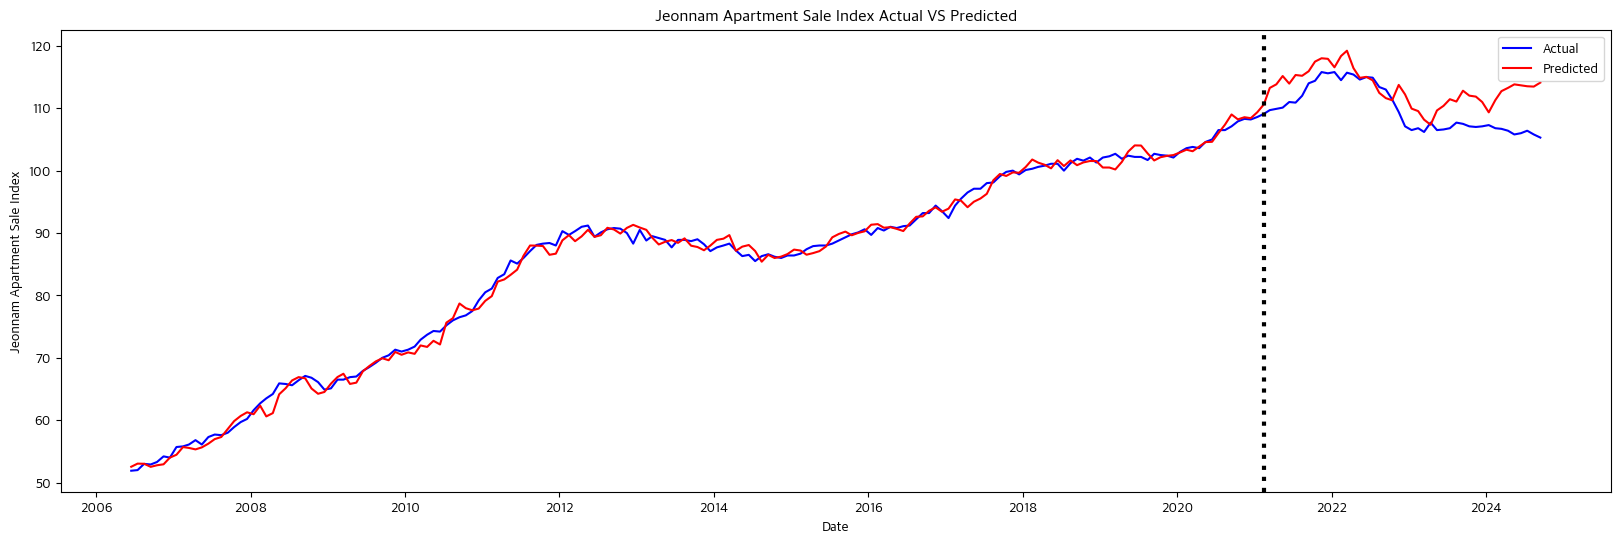

 27%|██▋       | 137/500 [00:04<00:10, 33.68it/s]


Early stopping triggered.


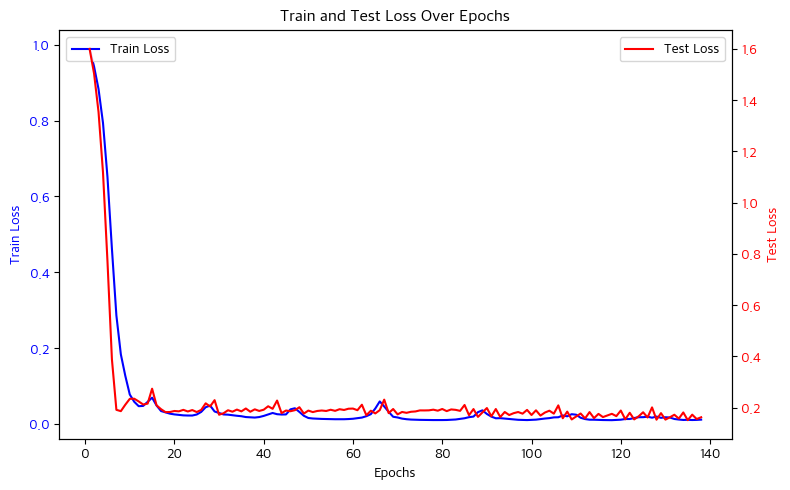

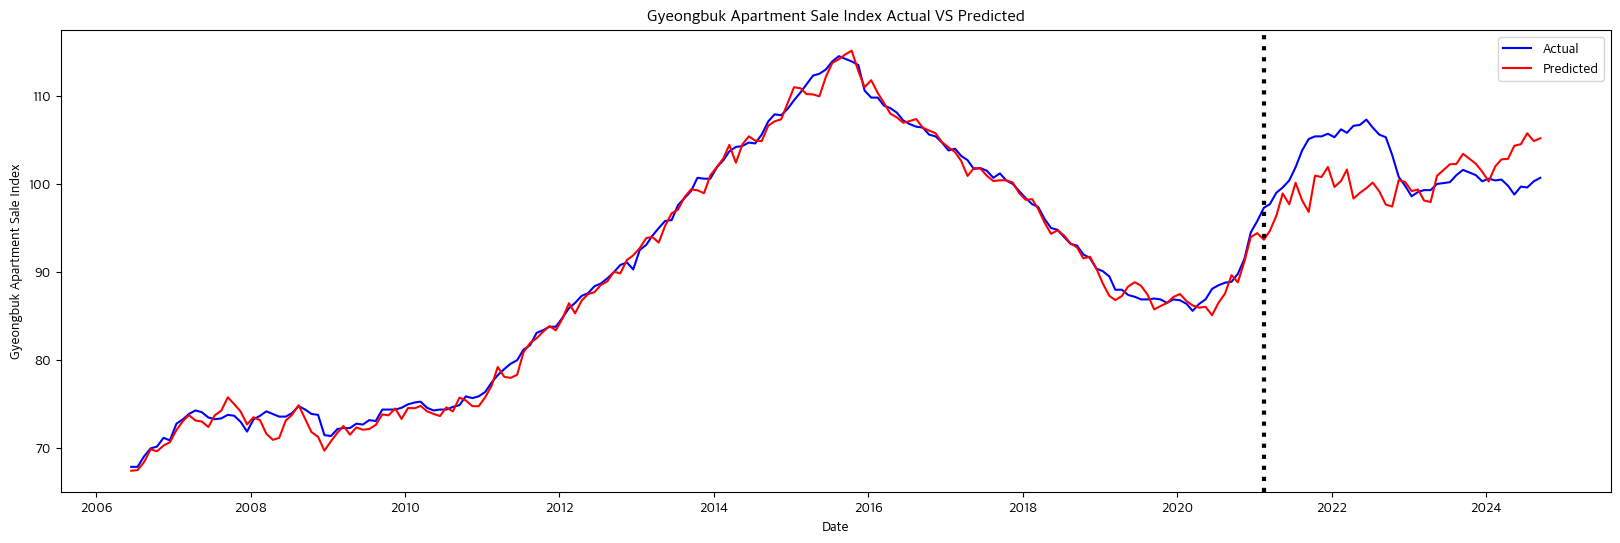

 23%|██▎       | 116/500 [00:03<00:12, 31.48it/s]


Early stopping triggered.


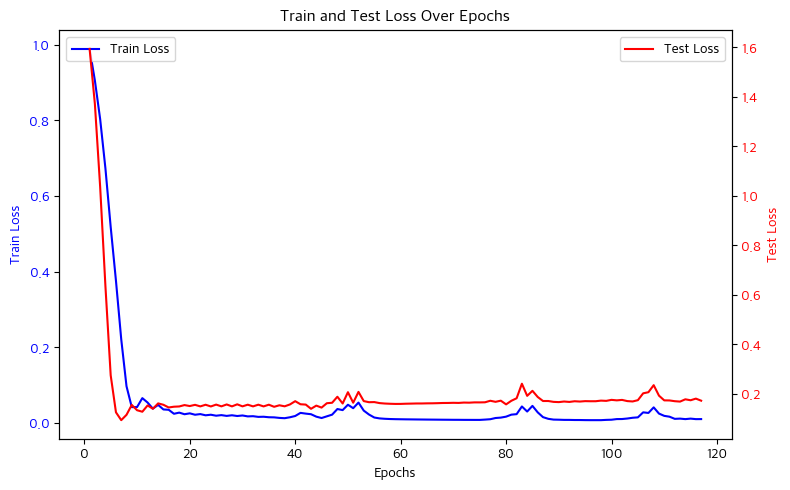

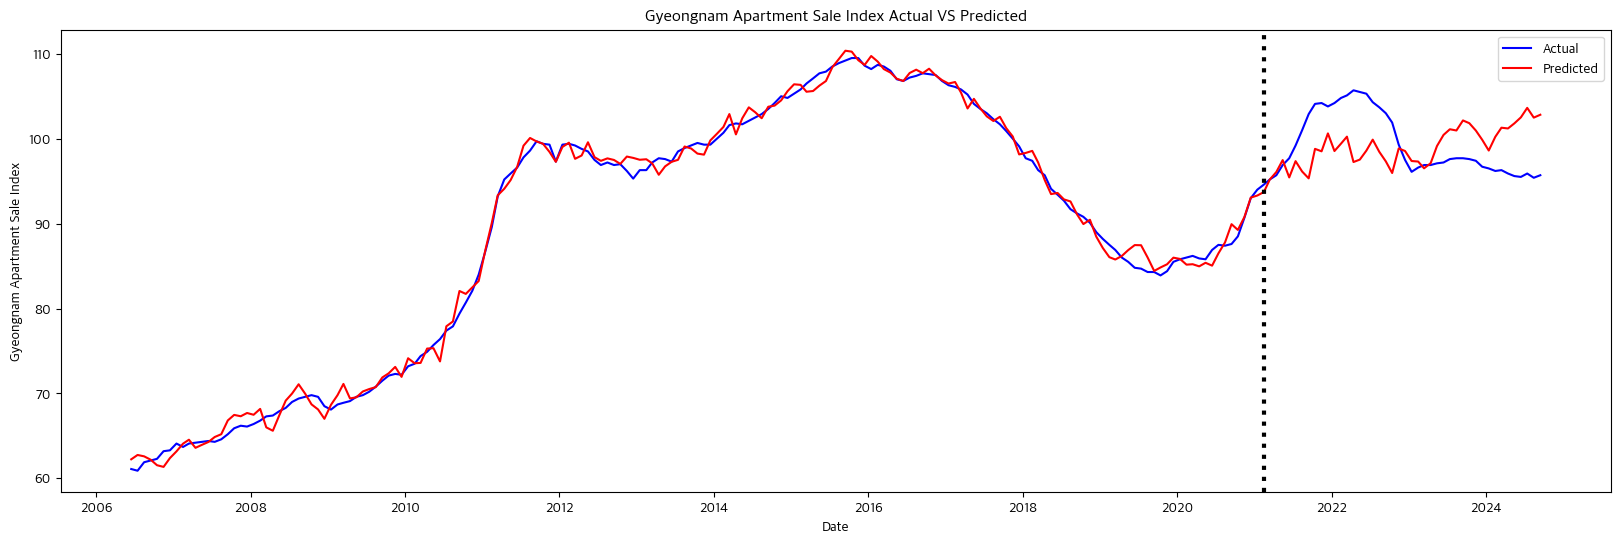

 25%|██▍       | 124/500 [00:03<00:12, 31.02it/s]


Early stopping triggered.


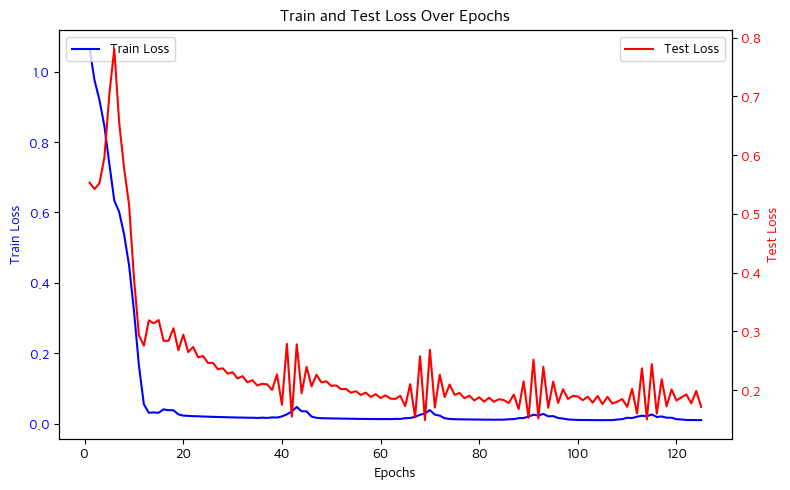

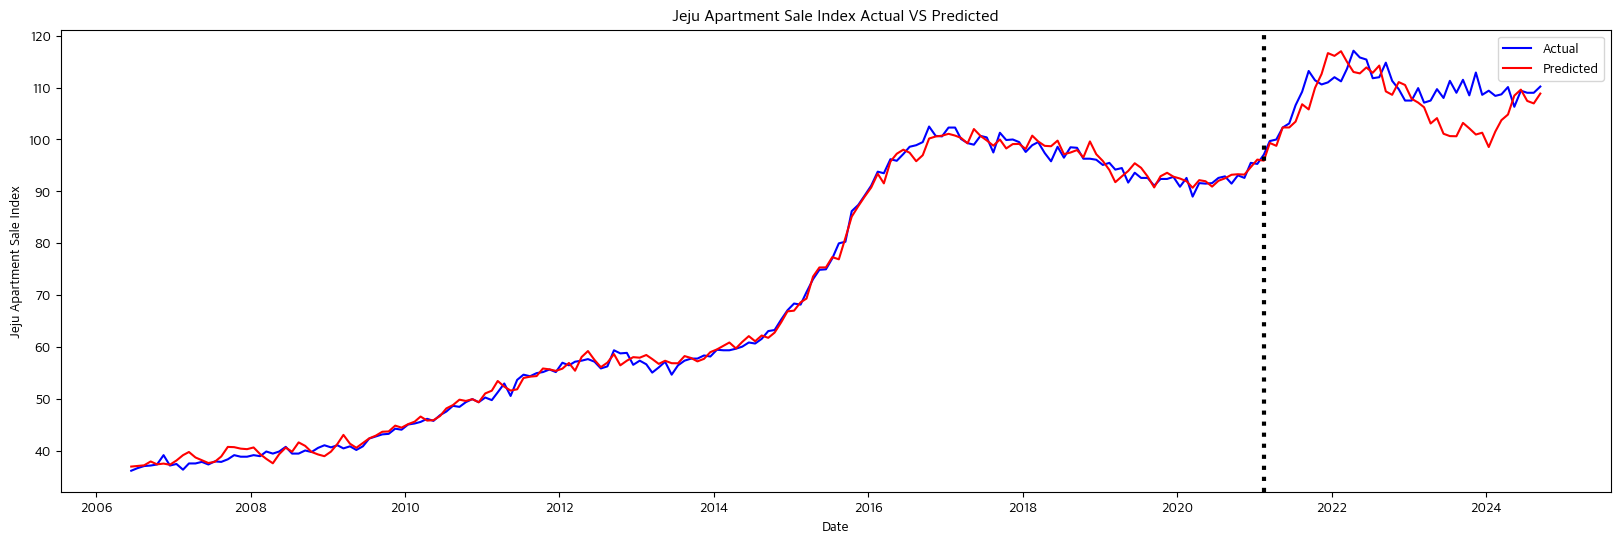

In [167]:
for i in range(len(resid.columns)):
    target = resid.columns[i] # target value
    
    df = pd.DataFrame([])
    df[['call_interest_rate_shift_A','real_GDP_growth_rate_shift_A', 'residential_building_start_status_shift_A']] = _df[['call_interest_rate','real_GDP_growth_rate', 'residential_building_start_status']].shift(3)
    df[['call_interest_rate_shift_B','real_GDP_growth_rate_shift_B', 'residential_building_start_status_shift_B']] = _df[['call_interest_rate','real_GDP_growth_rate', 'residential_building_start_status']].shift(4)
    df[['call_interest_rate_shift_C','real_GDP_growth_rate_shift_C', 'residential_building_start_status_shift_C']] = _df[['call_interest_rate','real_GDP_growth_rate', 'residential_building_start_status']].shift(5)
    df[f"{target}_shift_A"] = resid.shift(3)[target]
    df[f"{target}_shift_B"] = resid.shift(4)[target]
    df[f"{target}_shift_C"] = resid.shift(5)[target]
    df[f"{target}"] = resid[target]
    df = df.dropna()
    
    x_df = df.drop([target],axis=1)
    y_df = df[f"{target}"]

    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle=False)
    train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
    
    x_df_mu, x_df_std = X_train.mean(), X_train.std()
    y_df_mu, y_df_std = y_train.mean(), y_train.std()

    X_train = z_transform(X_train, x_df_mu, x_df_std)
    X_test = z_transform(X_test, x_df_mu, x_df_std)
    y_train = z_transform(y_train, y_df_mu, y_df_std)
    y_test = z_transform(y_test, y_df_mu, y_df_std)

    # hyperparameter
    input_size = len(df.columns)-1
    hidden_size = 64
    output_size = 1
    learning_rate = 0.0008
    epochs = 500
    patience = 20
    batch_size = 16

    # Dataset, DataLoader 
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, Loss function, Optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_size, hidden_size, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping intialize
    best_train_loss = float('inf')
    patience_counter = 0
    _loss = []
    test_loss_list = []
    # train loop
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
        _loss.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            test_loss_list_epoch = []
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss = criterion(outputs, y_batch.unsqueeze(-1))
                test_loss_list_epoch.append(test_loss.item())
                
            test_loss = np.mean(test_loss_list_epoch)
            test_loss_list.append(test_loss)
        
        # Early stopping Check
        if train_loss < best_train_loss:
            best_train_loss = train_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_{target}.pth") 
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
        # print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}")
    
    
    # Evaluate Test data
    model.load_state_dict(torch.load(f"best_model_{target}.pth"))  # Load Best Model
    model.eval()

    # Plot Loss graph
    fig, ax1 = plt.subplots(figsize=(8, 5))
    epochs = range(1, len(_loss) + 1)
    ax1.plot(epochs, _loss, label='Train Loss', color='b')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel("Train Loss",color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc="upper left")
    ax2 = ax1.twinx()
    ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel("Test Loss",color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc="upper right") 
    plt.title('Train and Test Loss Over Epochs')
    fig.tight_layout()
    plt.show()
    
    # Get predictions
    train_predictions, train_targets = predict(model, train_loader, device)
    test_predictions, test_targets = predict(model, test_loader, device)

    real = inv_z_transform(pd.DataFrame(test_targets),y_df_mu,y_df_std)
    pred = inv_z_transform(pd.DataFrame(test_predictions),y_df_mu,y_df_std)
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    
    delta_y = np.diff(np.array(real).flatten())
    delta_y_hat = np.diff(np.array(pred).flatten())
    di = (np.sign(delta_y) == np.sign(delta_y_hat)).astype(int)
    DS = round(100 * np.sum(di) / len(di), 3)
    val =[target,rmse,r2,DS]

    # common factors 
    f = factor1_df * fa.loadings_[i][0] + factor2_df * fa.loadings_[i][1]
    f = f*100/f[142]
    
    # add Predicted Individual(Resid)
    real_dd = inv_z_transform(pd.DataFrame(train_targets+test_targets, index=df.index),y_df_mu,y_df_std)
    pred_dd = inv_z_transform(pd.DataFrame(train_predictions+test_predictions, index=df.index),y_df_mu,y_df_std)
    # pred_dd = pd.DataFrame([0]*len(df), index=df.index) # Ablation
    
    plt.figure(figsize=(20,6))
    plt.title(f"{target} Apartment Sale Index Actual VS Predicted")
    
    plt.plot(pd.to_datetime(df.index),(pd.DataFrame(f) + real_dd).dropna(),c='b',label="Actual")
    plt.plot(pd.to_datetime(df.index),(pd.DataFrame(f) + pred_dd).dropna(),c='r',label="Predicted")
    plt.axvline(x=pd.to_datetime(test_df.index[0]), color='black', linestyle=':', linewidth=3)
    plt.xlabel('Date')
    plt.ylabel(f"{target} Apartment Sale Index")
    plt.legend()
    plt.show()
    pd.DataFrame(val).T.to_csv("./result.csv", mode='a', header=False, index=False)


create graph image

In [135]:
# Create the structure of the MLP model as a graph
dot = Digraph(comment='MLP Model Visualization')

# Add nodes for each layer
dot.node('Input', 'Input Layer\n(input_size)', shape='ellipse', color='lightblue')
dot.node('fc1', 'Fully Connected 1\n(128 neurons)', shape='box')
dot.node('fc2', 'Fully Connected 2\n(64 neurons)', shape='box')
dot.node('fc3', 'Fully Connected 3\n(32 neurons)', shape='box')
dot.node('fc4', 'Fully Connected 4\n(16 neurons)', shape='box')
dot.node('fc5', 'Fully Connected 5\n(1 neuron)', shape='box', color='orange')
dot.node('Output', 'Output Layer\n(1 scalar)', shape='ellipse', color='green')

# Add edges between the layers
dot.edges([
    ('Input', 'fc1'),
    ('fc1', 'fc2'),
    ('fc2', 'fc3'),
    ('fc3', 'fc4'),
    ('fc4', 'fc5'),
    ('fc5', 'Output')
])

# Save and render the graph to a file
output_path = 'mlp_model'
dot.render(output_path, format='png', view=False)


'mlp_model.png'

### Evaluate

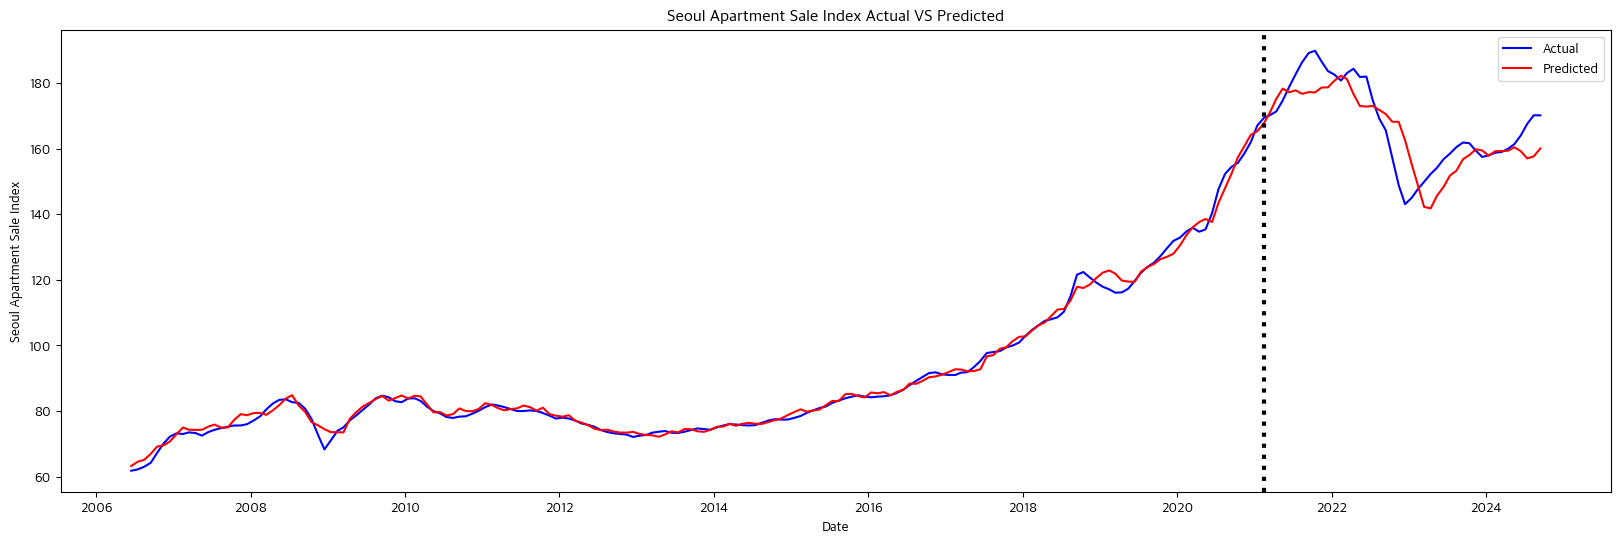

[Seoul Result]   RMSE: 7.74, R-square: 0.48, Directional Symmetry:39.53%


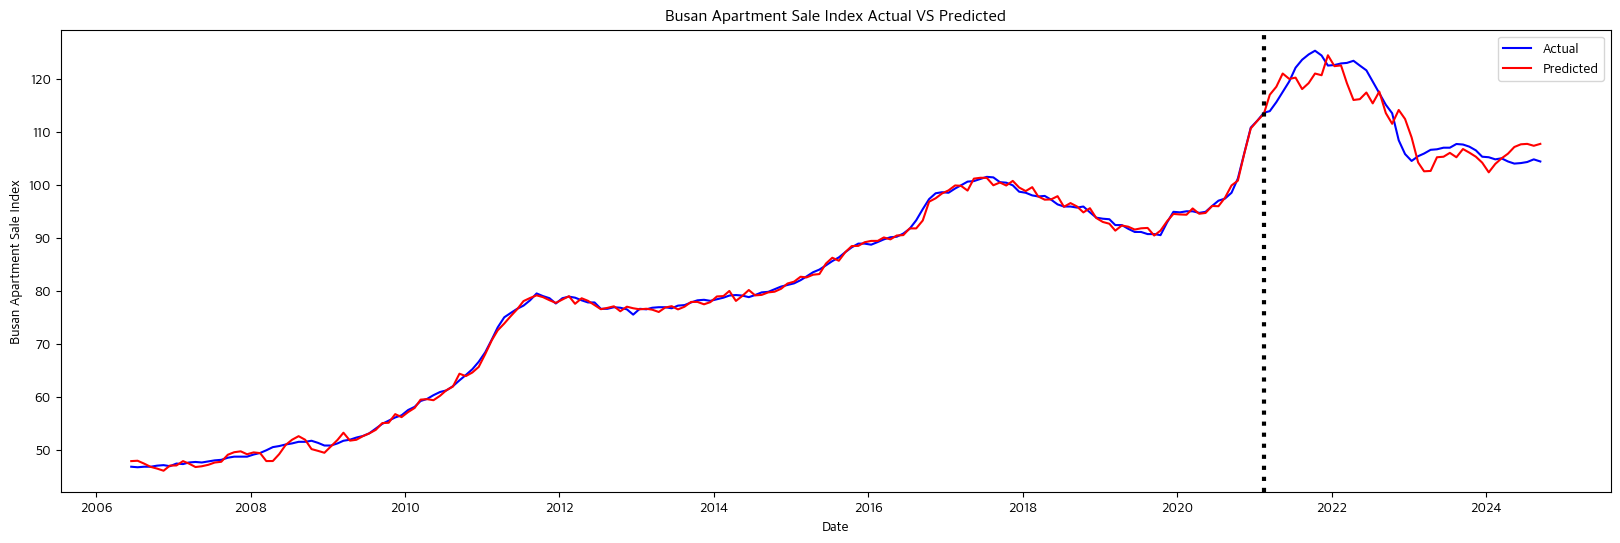

[Busan Result]   RMSE: 3.32, R-square: 0.76, Directional Symmetry:53.49%


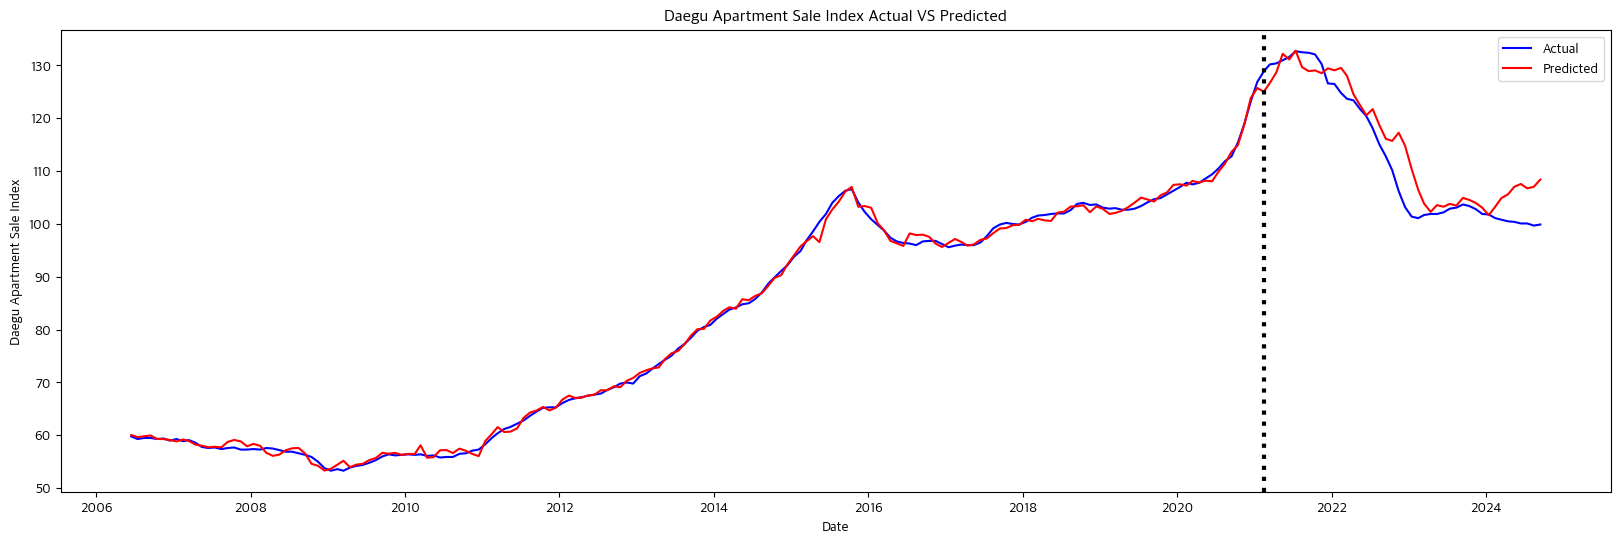

[Daegu Result]   RMSE: 4.5, R-square: 0.86, Directional Symmetry:65.12%


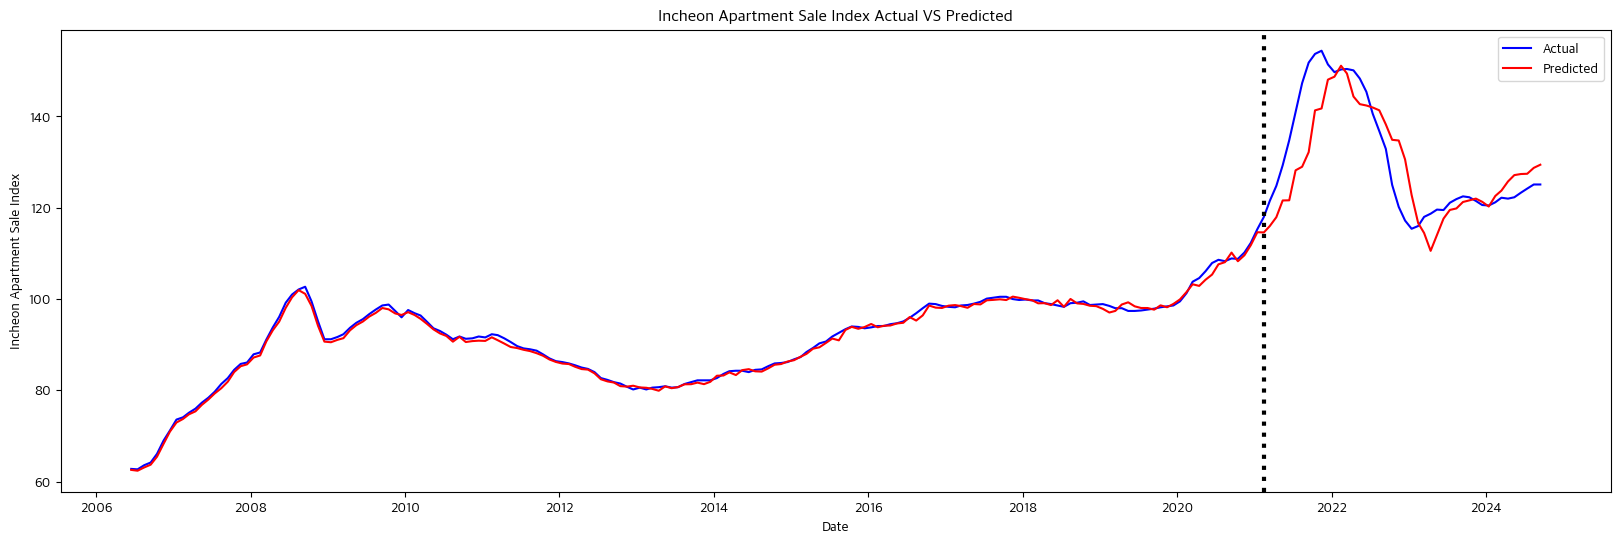

[Incheon Result]   RMSE: 7.42, R-square: 0.53, Directional Symmetry:55.81%


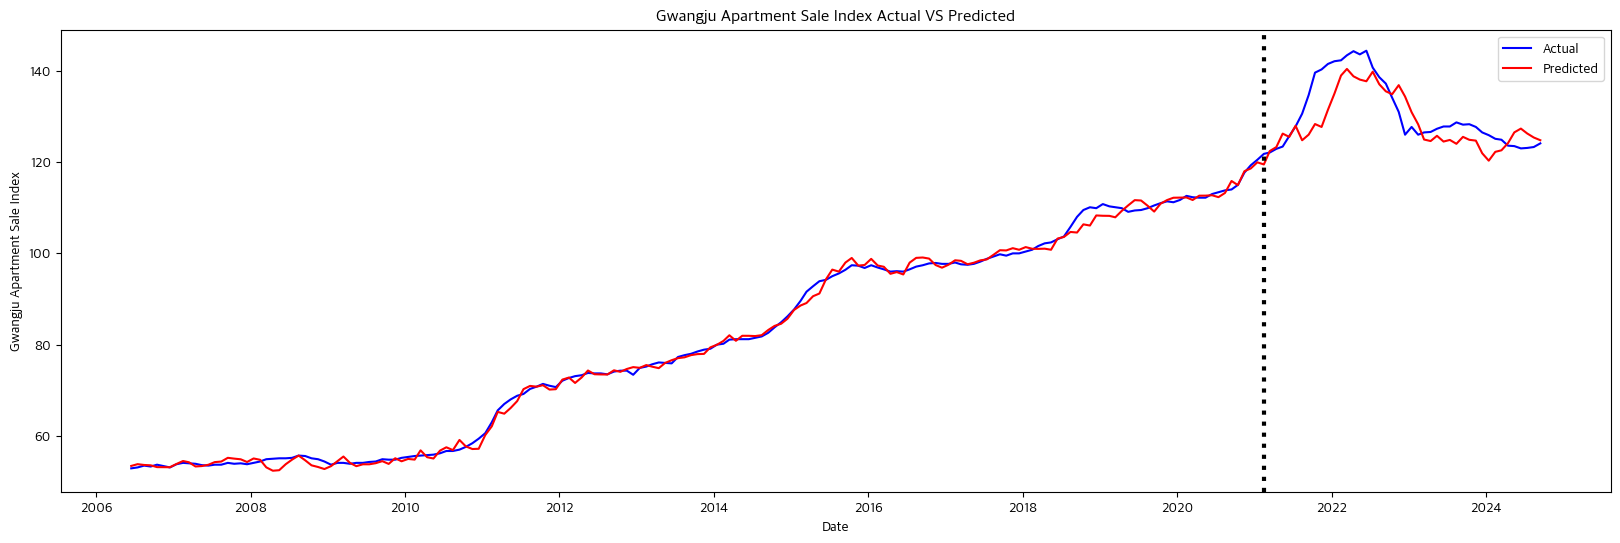

[Gwangju Result]   RMSE: 4.77, R-square: 0.52, Directional Symmetry:58.14%


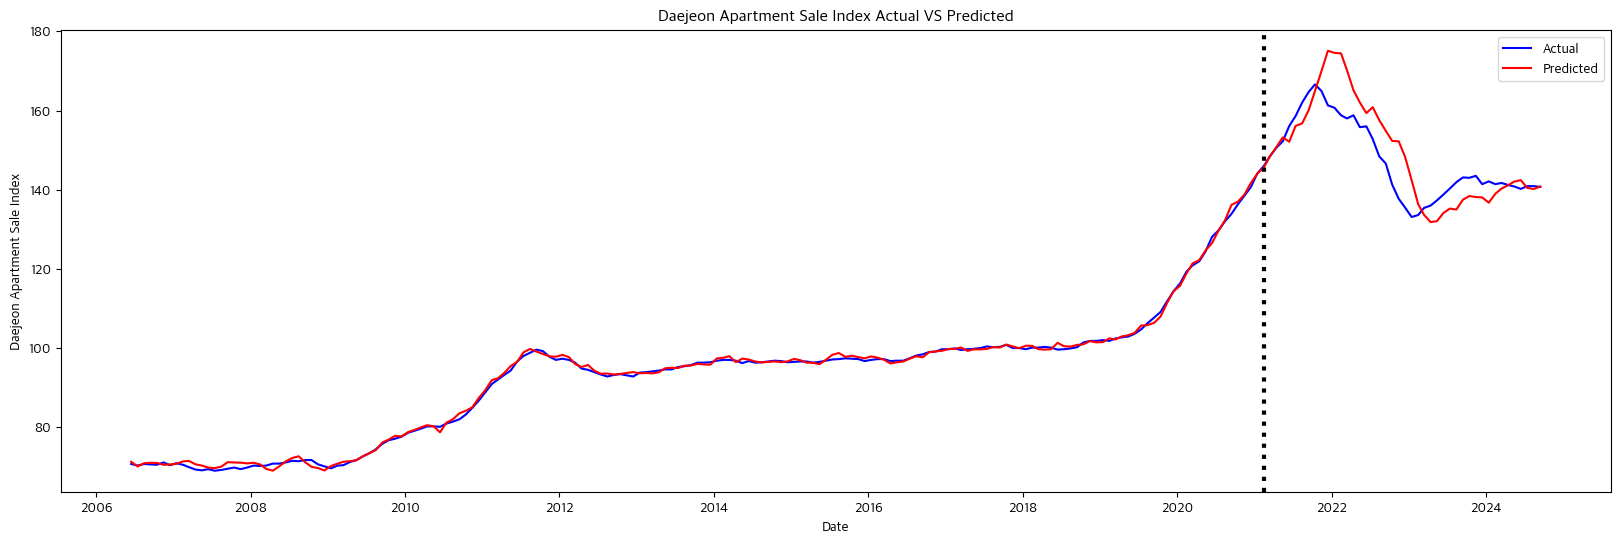

[Daejeon Result]   RMSE: 6.84, R-square: 0.23, Directional Symmetry:55.81%


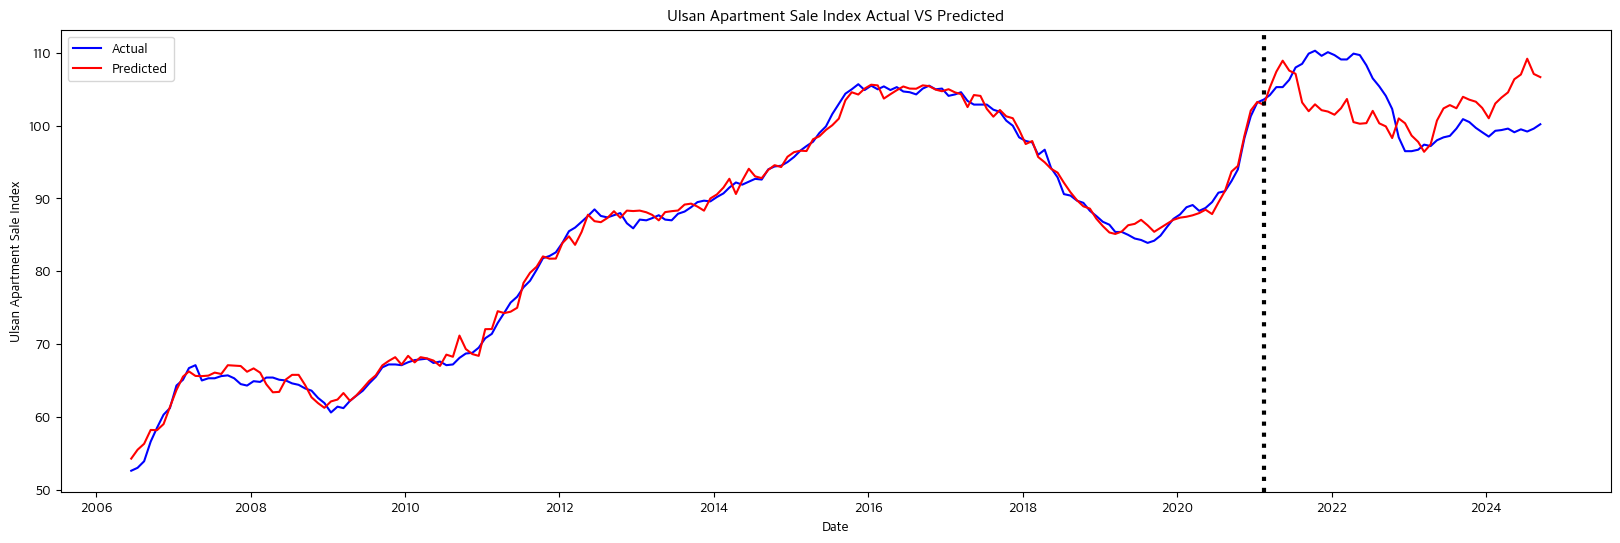

[Ulsan Result]   RMSE: 5.32, R-square: -1.24, Directional Symmetry:53.49%


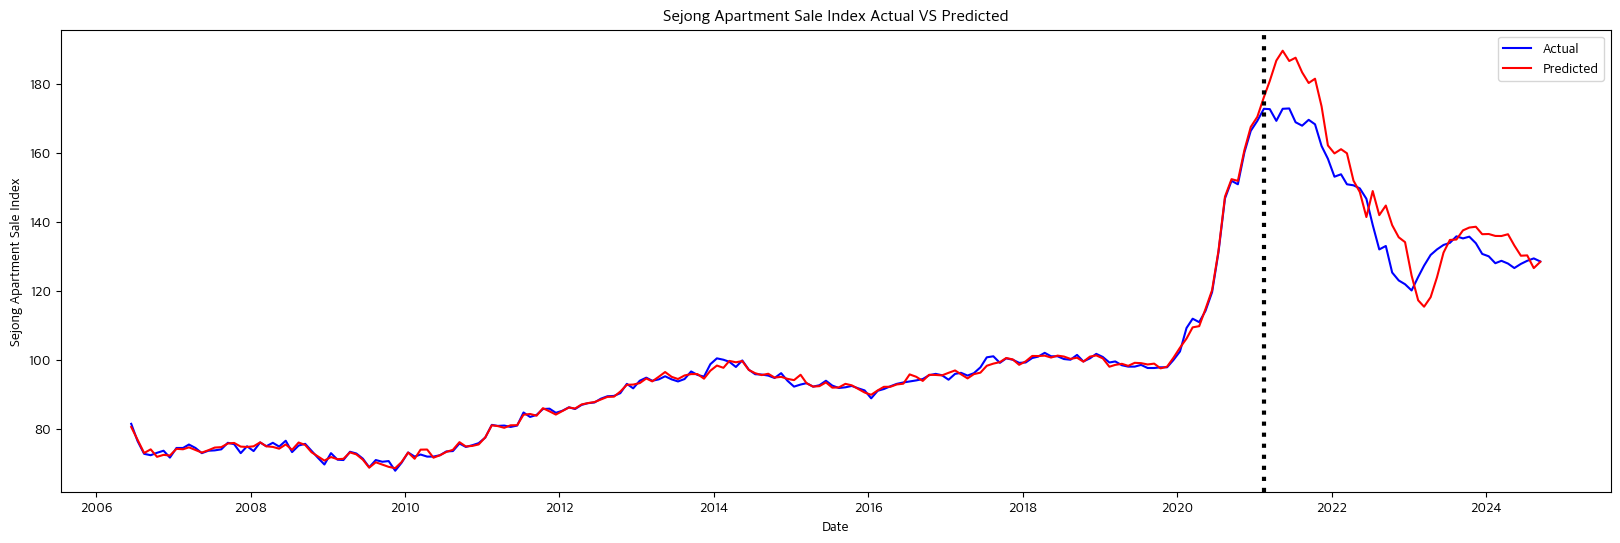

[Sejong Result]   RMSE: 9.18, R-square: 0.69, Directional Symmetry:53.49%


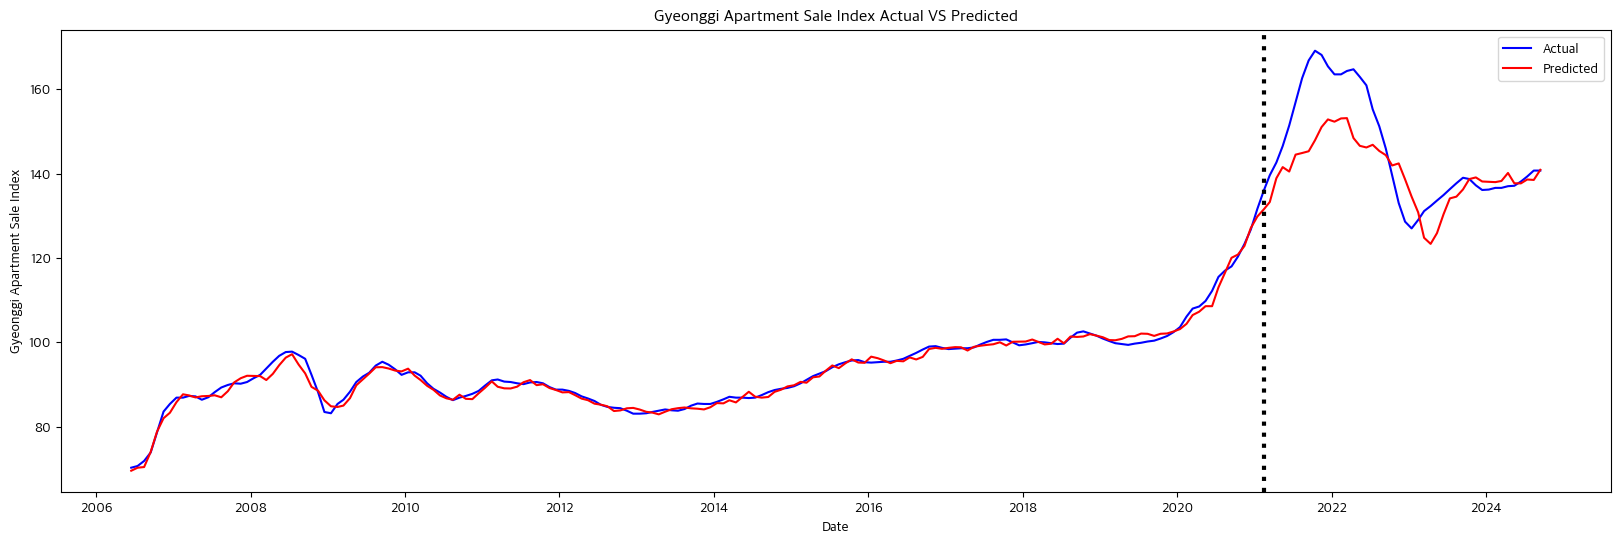

[Gyeonggi Result]   RMSE: 9.26, R-square: 0.25, Directional Symmetry:48.84%


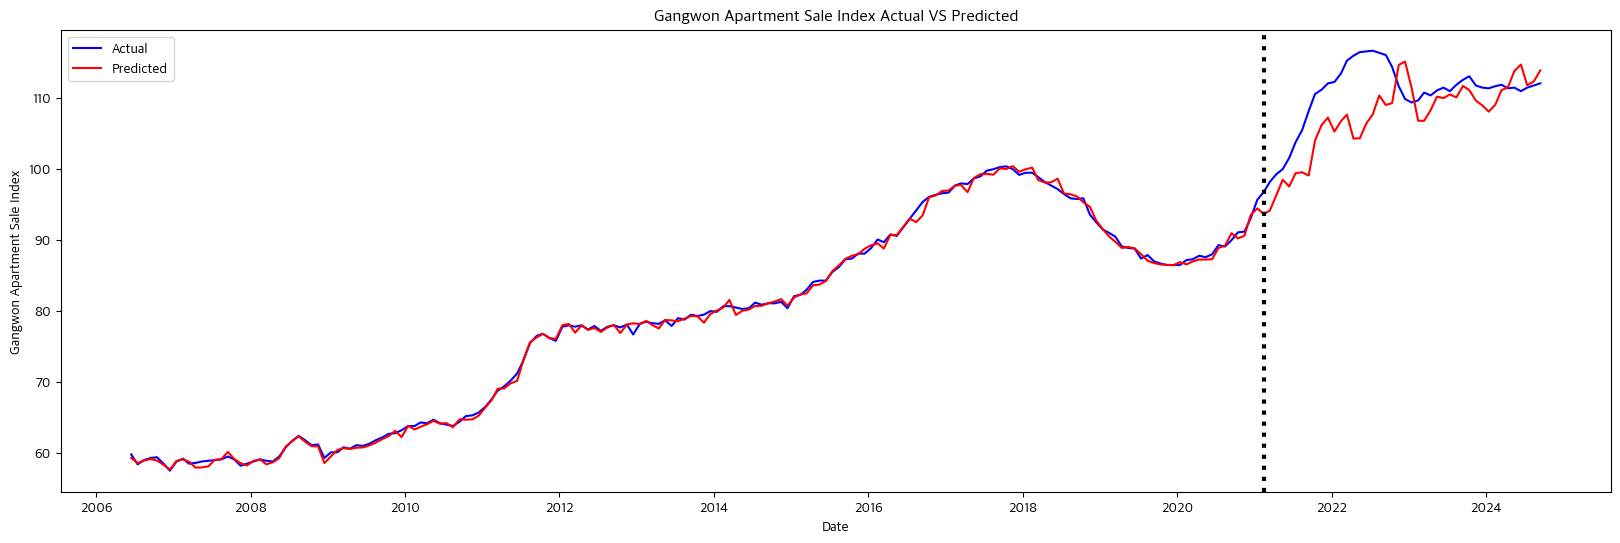

[Gangwon Result]   RMSE: 5.1, R-square: 0.16, Directional Symmetry:53.49%


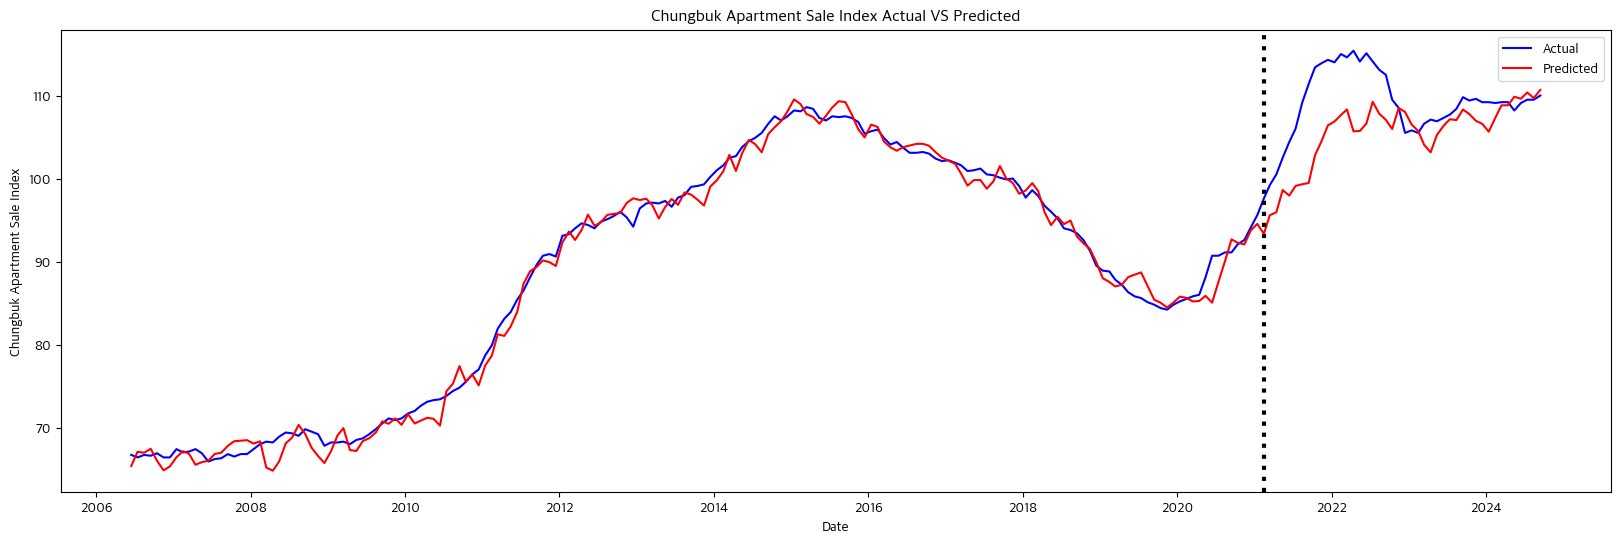

[Chungbuk Result]   RMSE: 5.23, R-square: -0.54, Directional Symmetry:62.79%


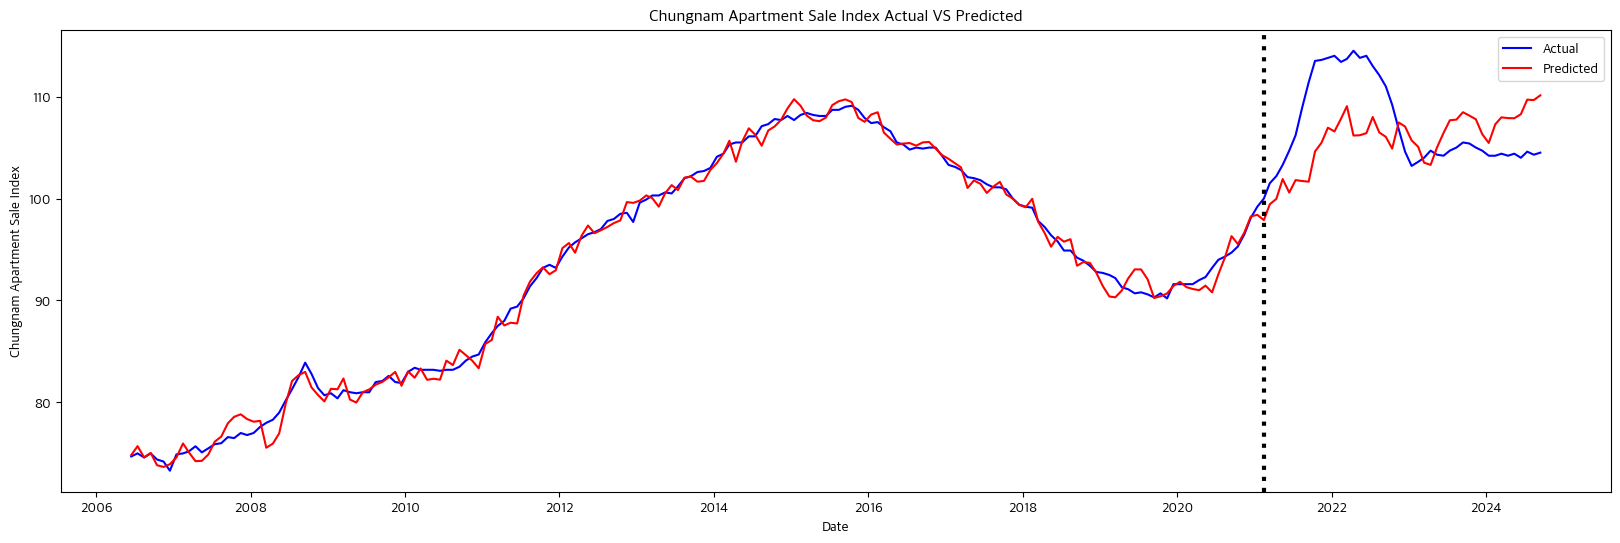

[Chungnam Result]   RMSE: 4.77, R-square: -0.35, Directional Symmetry:62.79%


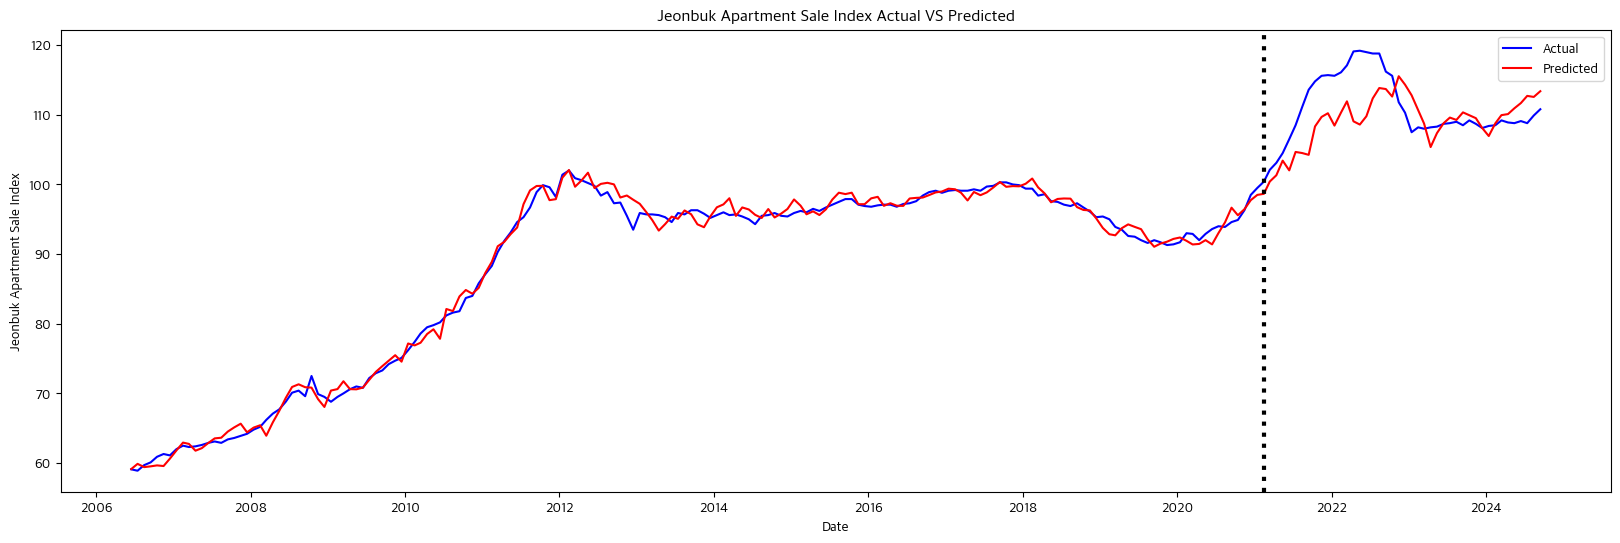

[Jeonbuk Result]   RMSE: 4.51, R-square: 0.09, Directional Symmetry:62.79%


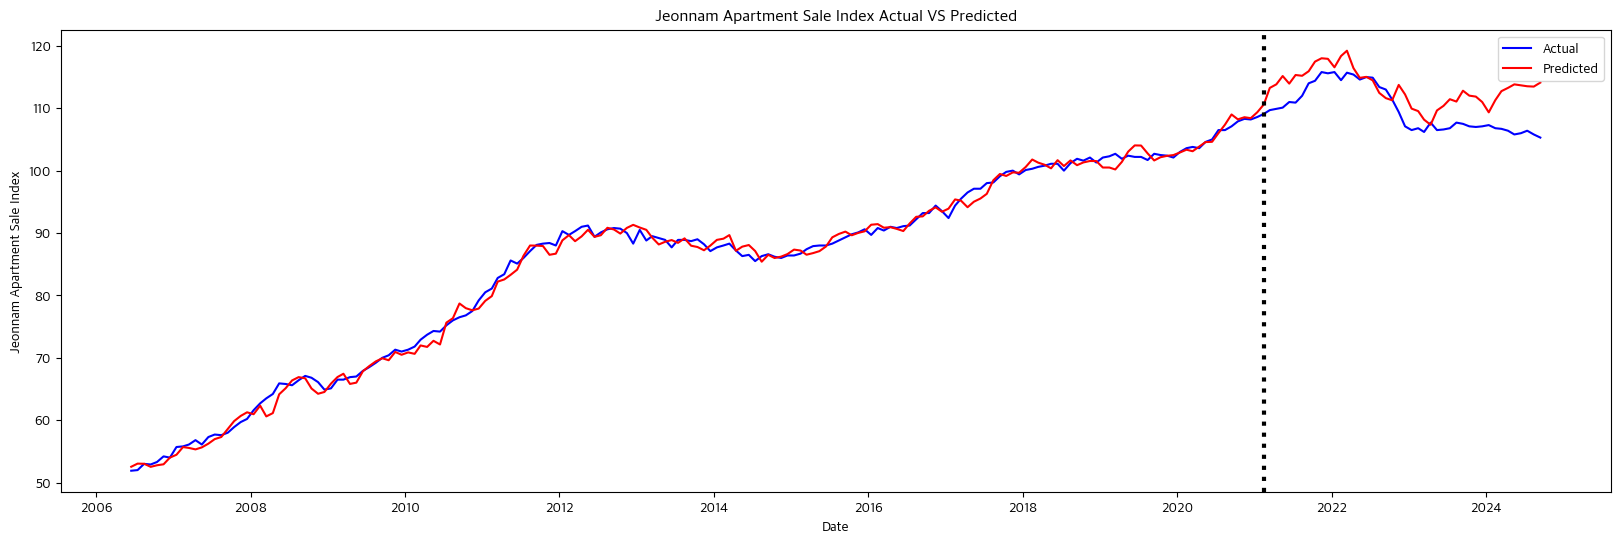

[Jeonnam Result]   RMSE: 4.23, R-square: -0.29, Directional Symmetry:46.51%


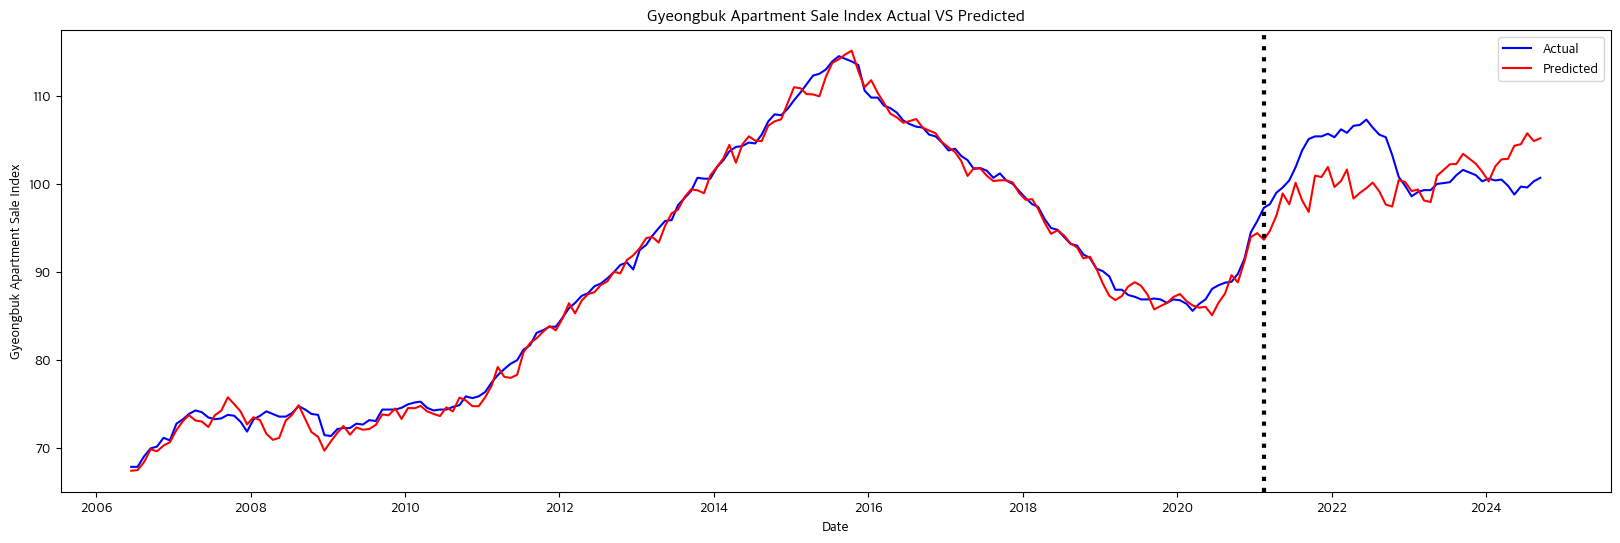

[Gyeongbuk Result]   RMSE: 4.3, R-square: -0.81, Directional Symmetry:46.51%


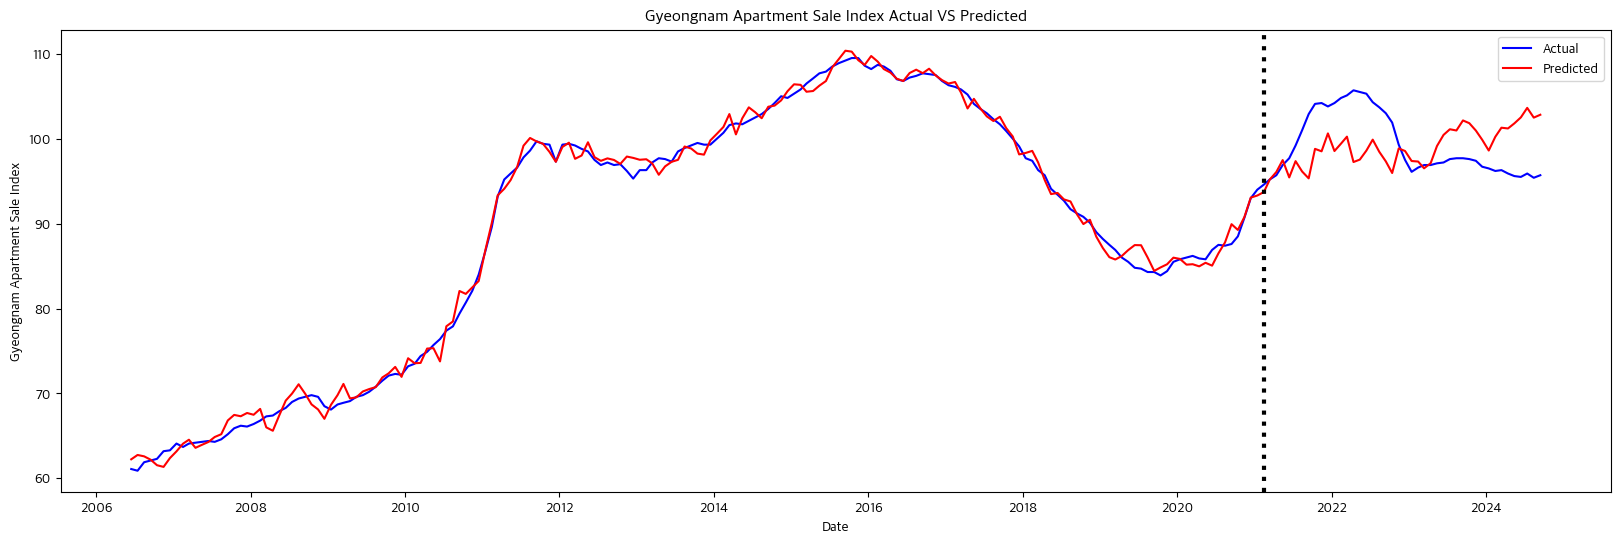

[Gyeongnam Result]   RMSE: 4.68, R-square: -0.45, Directional Symmetry:55.81%


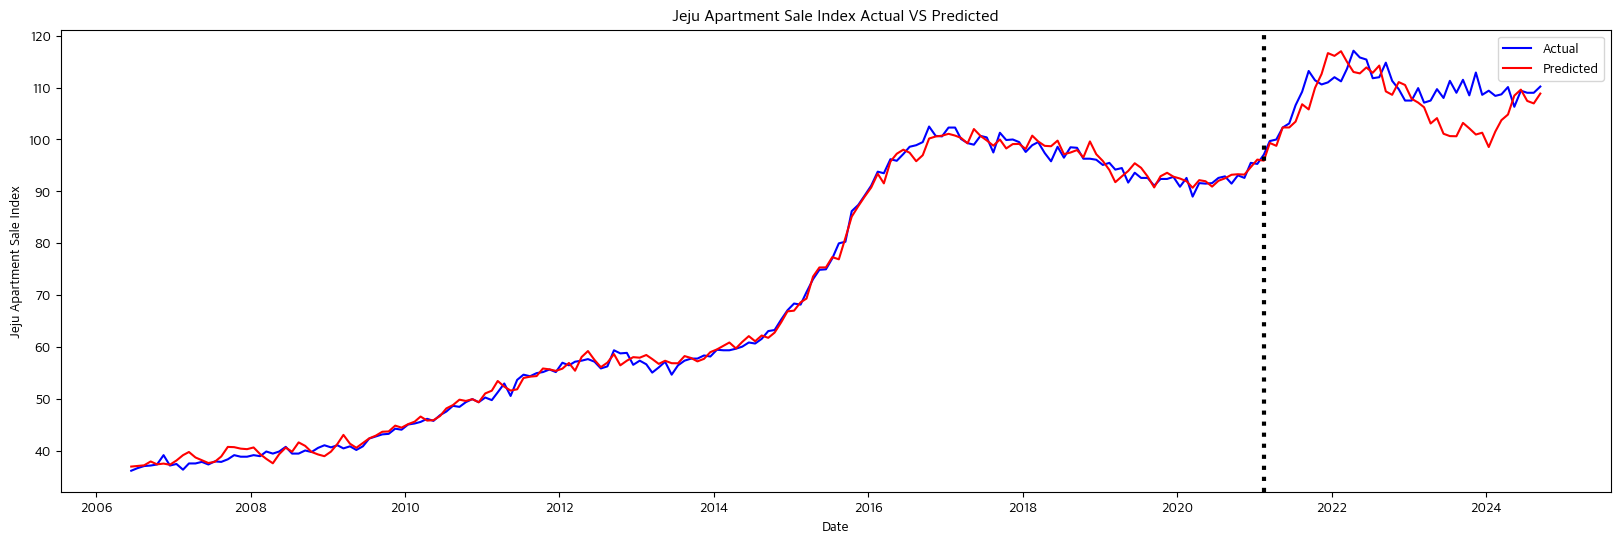

[Jeju Result]   RMSE: 4.94, R-square: -0.19, Directional Symmetry:48.84%


In [174]:
for i in range(len(resid.columns)):
    target = resid.columns[i] # target value
    
    df = pd.DataFrame([])
    df[['call_interest_rate_shift_A','real_GDP_growth_rate_shift_A', 'residential_building_start_status_shift_A']] = _df[['call_interest_rate','real_GDP_growth_rate', 'residential_building_start_status']].shift(3)
    df[['call_interest_rate_shift_B','real_GDP_growth_rate_shift_B', 'residential_building_start_status_shift_B']] = _df[['call_interest_rate','real_GDP_growth_rate', 'residential_building_start_status']].shift(4)
    df[['call_interest_rate_shift_C','real_GDP_growth_rate_shift_C', 'residential_building_start_status_shift_C']] = _df[['call_interest_rate','real_GDP_growth_rate', 'residential_building_start_status']].shift(5)
    df[f"{target}_shift_A"] = resid.shift(3)[target]
    df[f"{target}_shift_B"] = resid.shift(4)[target]
    df[f"{target}_shift_C"] = resid.shift(5)[target]
    df[f"{target}"] = resid[target]
    df = df.dropna()
    
    x_df = df.drop([target],axis=1)
    y_df = df[f"{target}"]

    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle=False)
    train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
    
    x_df_mu, x_df_std = X_train.mean(), X_train.std()
    y_df_mu, y_df_std = y_train.mean(), y_train.std()

    X_train = z_transform(X_train, x_df_mu, x_df_std)
    X_test = z_transform(X_test, x_df_mu, x_df_std)
    y_train = z_transform(y_train, y_df_mu, y_df_std)
    y_test = z_transform(y_test, y_df_mu, y_df_std)

    # hyperparameter
    input_size = len(df.columns)-1
    hidden_size = 64
    output_size = 1
    batch_size = 16
    
    # Dataset, DataLoader
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_size, hidden_size, output_size).to(device)
    model.load_state_dict(torch.load(f"best_model_{target}.pth"))  # Load Optimal Model
    model.eval()

    # Get predictions
    train_predictions, train_targets = predict(model, train_loader, device)
    test_predictions, test_targets = predict(model, test_loader, device)

    real = inv_z_transform(pd.DataFrame(test_targets),y_df_mu,y_df_std)
    pred = inv_z_transform(pd.DataFrame(test_predictions),y_df_mu,y_df_std)
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    
    delta_y = np.diff(np.array(real).flatten())
    delta_y_hat = np.diff(np.array(pred).flatten())
    di = (np.sign(delta_y) == np.sign(delta_y_hat)).astype(int)
    DS = round(100 * np.sum(di) / len(di), 3)
    val =[target,rmse,r2,DS]

    # common factors 
    f = factor1_df * fa.loadings_[i][0] + factor2_df * fa.loadings_[i][1]
    f = f*100/f[142]
    
    # add Predicted Individual(Resid)
    real_dd = inv_z_transform(pd.DataFrame(train_targets+test_targets, index=df.index),y_df_mu,y_df_std)
    pred_dd = inv_z_transform(pd.DataFrame(train_predictions+test_predictions, index=df.index),y_df_mu,y_df_std)
    # pred_dd = pd.DataFrame([0]*len(df), index=df.index) # Ablation
    
    plt.figure(figsize=(20,6))
    plt.title(f"{target} Apartment Sale Index Actual VS Predicted")
    
    plt.plot(pd.to_datetime(df.index),(pd.DataFrame(f) + real_dd).dropna(),c='b',label="Actual")
    plt.plot(pd.to_datetime(df.index),(pd.DataFrame(f) + pred_dd).dropna(),c='r',label="Predicted")
    plt.axvline(x=pd.to_datetime(test_df.index[0]), color='black', linestyle=':', linewidth=3)
    plt.xlabel('Date')
    plt.ylabel(f"{target} Apartment Sale Index")
    plt.legend()
    plt.show()
    
    print(f'[{target} Result]   RMSE: {round(rmse,2)}, R-square: {round(r2,2)}, Directional Symmetry:{round(DS,2)}%')

In [220]:
print(pd.to_datetime(test_df.index[-1]))

2024-08-15 00:00:00
